In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv1D, \
                         Flatten, MaxPooling1D, BatchNormalization
from keras.models import Sequential
from keras.callbacks import TensorBoard
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read Data
data = pd.read_csv('UrbanSounds8K/metadata/UrbanSound8K.csv')
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
data.shape

(8732, 8)

In [3]:
# Get data over 3 seconds long
valid_data = data[['slice_file_name', 'fold' ,'classID', 'class']][ data['end']-data['start'] >= 3 ]
valid_data.shape

(7468, 4)

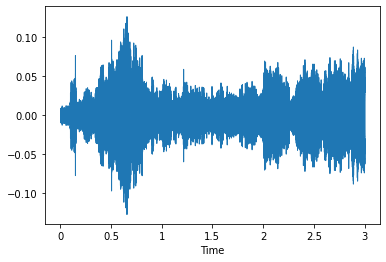

In [7]:
y, sr = librosa.load('UrbanSounds8K/audio/fold9/13579-2-0-16.wav', mono=True ,duration=3)
fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(y, sr=sr, ax=ax)

hi


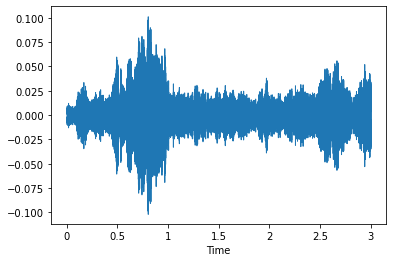

In [6]:
y, sr = librosa.load('UrbanSounds8K/augmented/speed_81/fold9/13579-2-0-16.wav', mono=True ,duration=3)
fig, ax = plt.subplots(nrows=1, sharex=True)
spectrogram=librosa.display.waveshow(y, sr=sr, ax=ax)
print("hi")


In [4]:
valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype('str')

In [5]:

#Use it to create data ######################################################################
def creates_train_data():
    D = [] # Dataset
    i=0
    for row in valid_data.itertuples():
        y, sr = librosa.load('UrbanSounds8K/audio/' + row.path, mono=True ,duration=3)  #2.97 = 3*1000 - 3*1000/128  ###############################
        fig, ax = plt.subplots(nrows=1, sharex=True)
        spectrogram=librosa.display.waveshow(y, sr=sr, ax=ax)

        D.append( (spectrogram, row.classID) )

    np.save('figure_raw_train_data.npy', D) ###############################
    return D
creates_train_data()

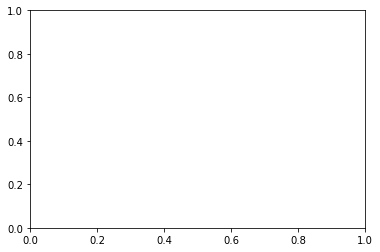

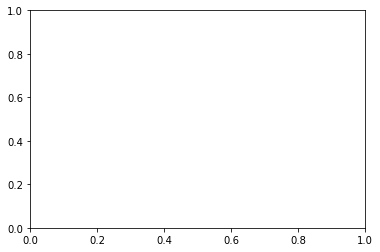

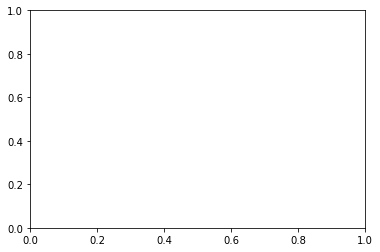

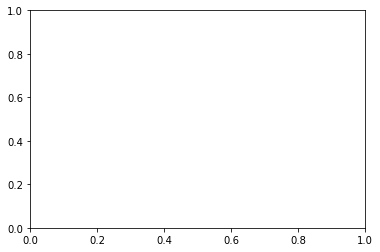

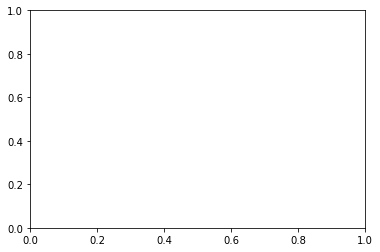

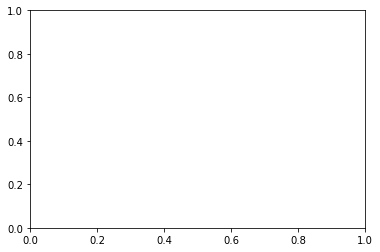

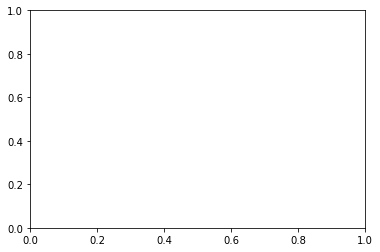

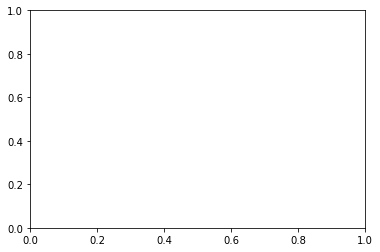

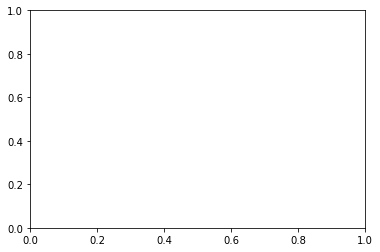

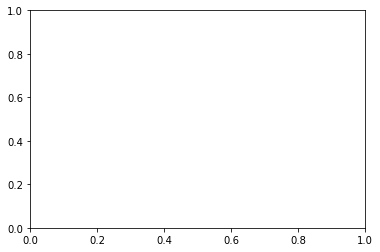

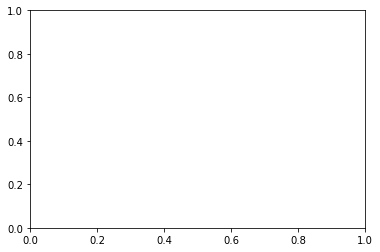

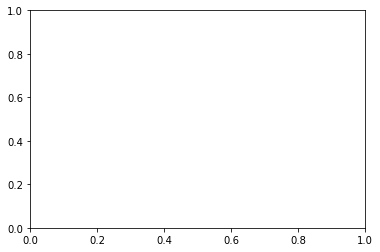

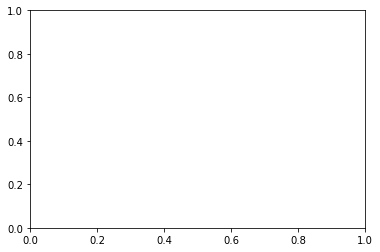

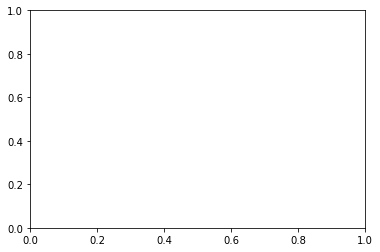

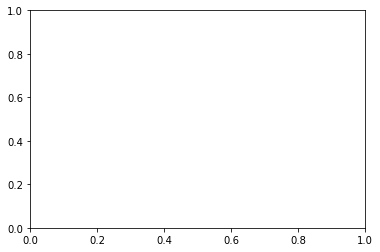

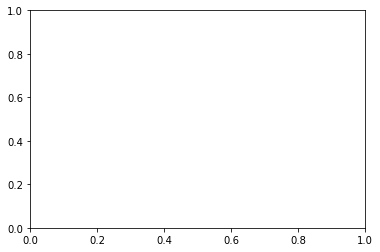

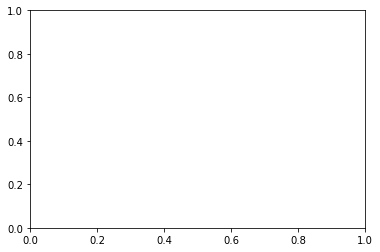

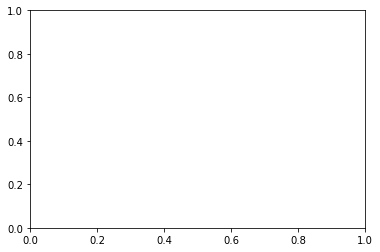

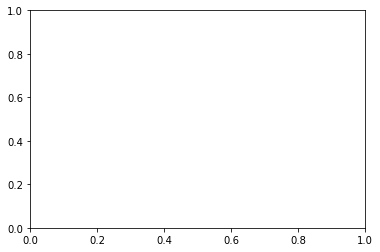

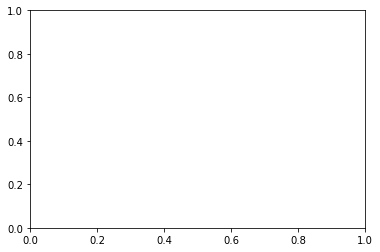

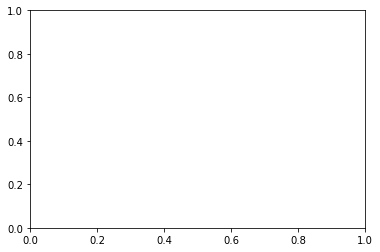

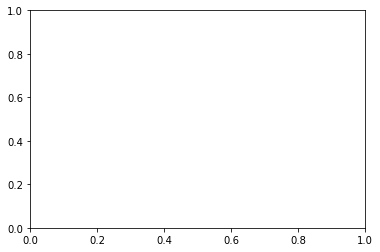

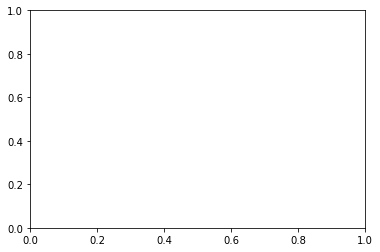

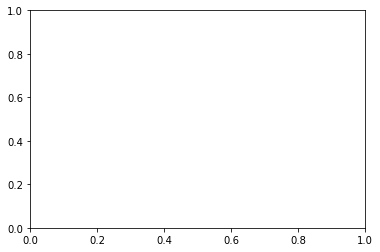

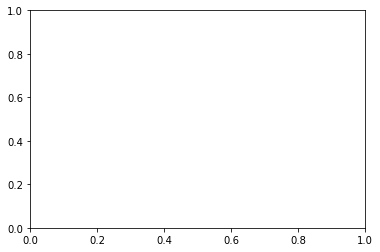

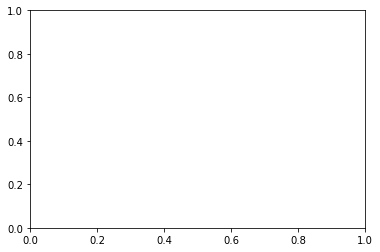

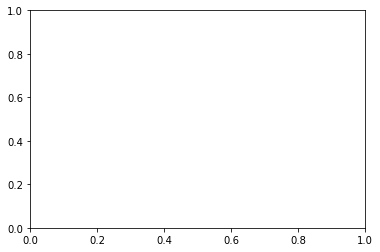

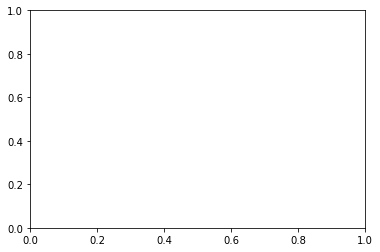

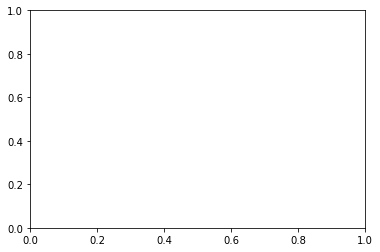

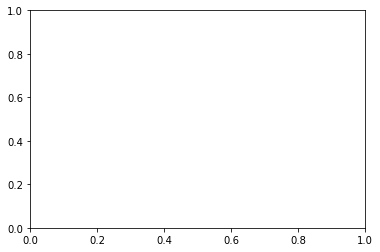

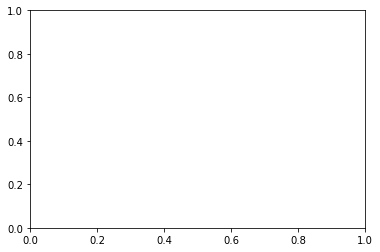

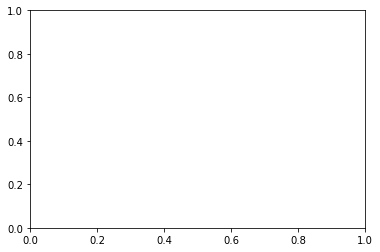

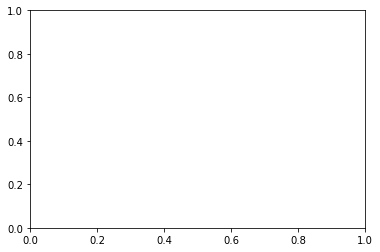

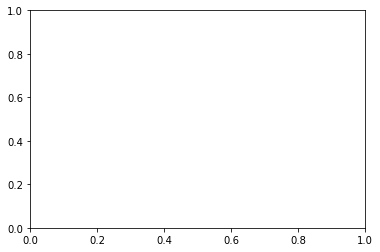

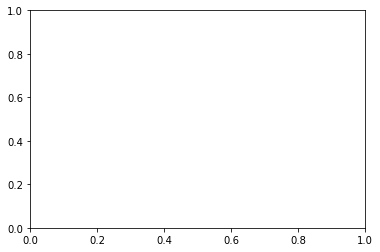

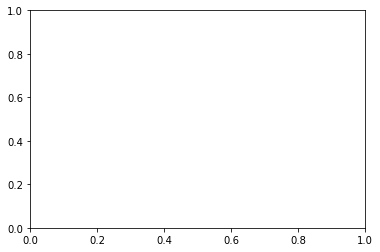

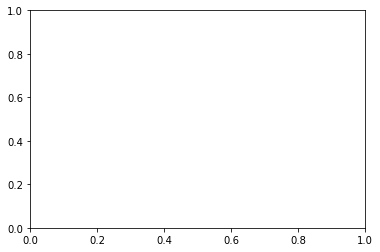

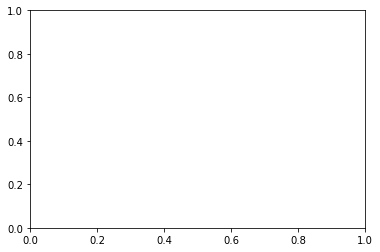

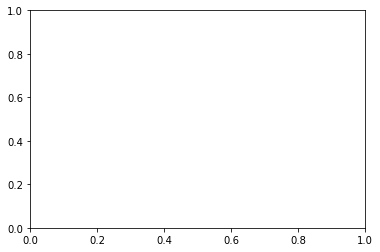

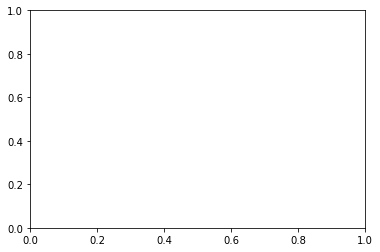

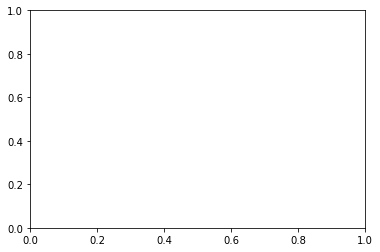

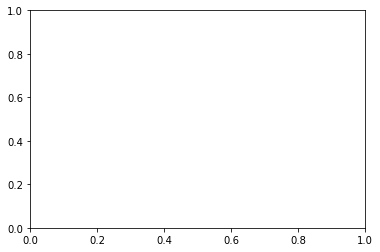

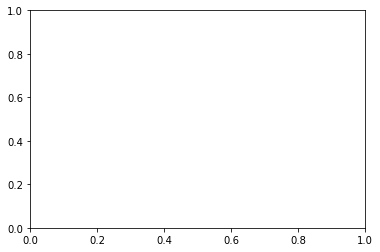

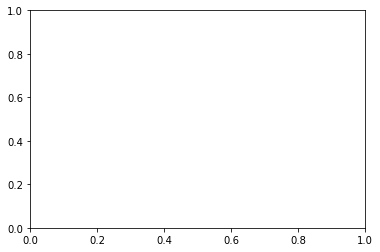

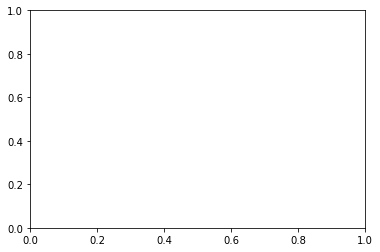

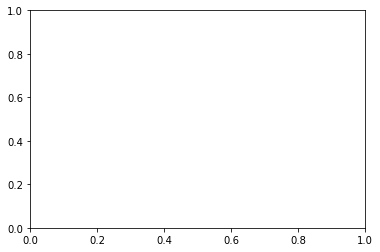

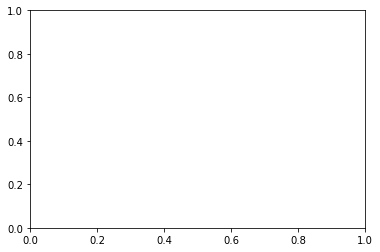

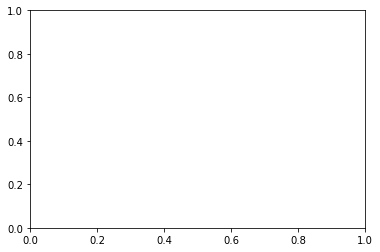

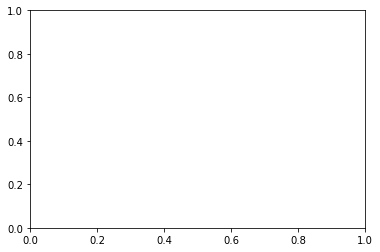

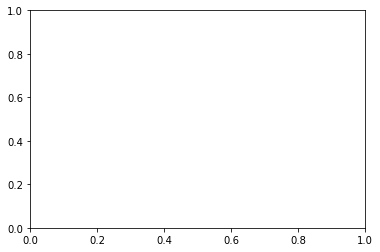

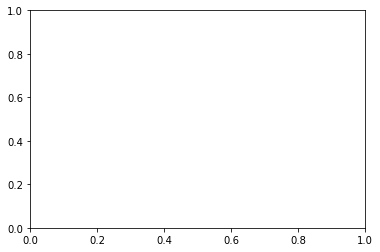

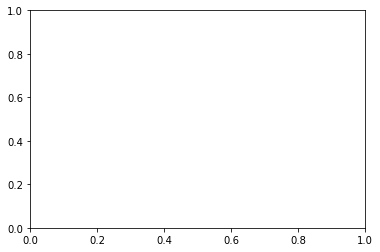

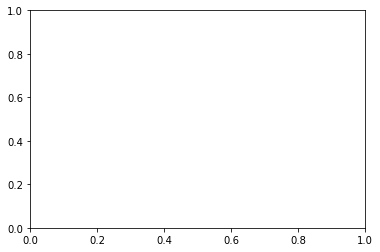

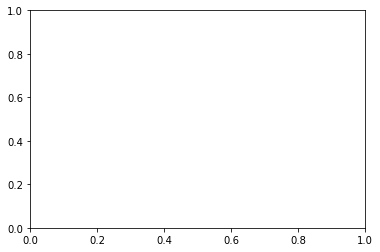

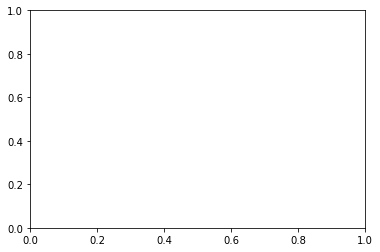

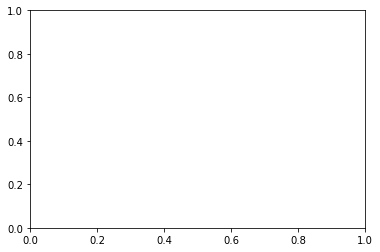

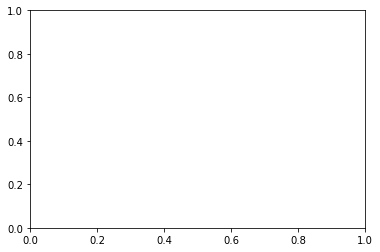

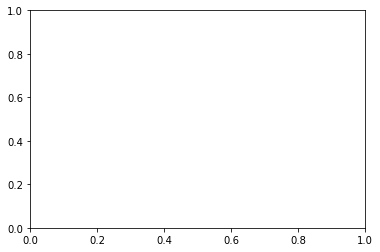

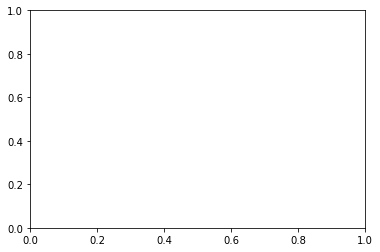

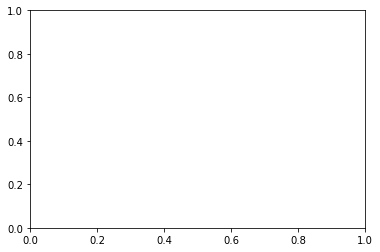

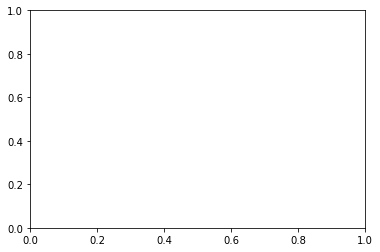

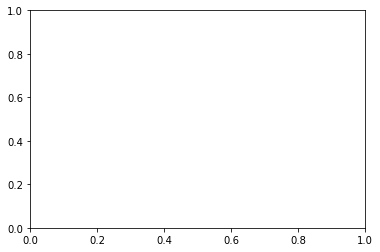

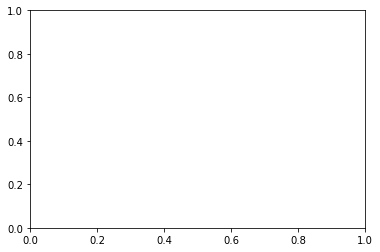

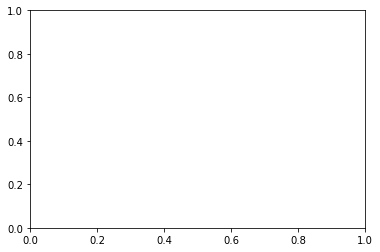

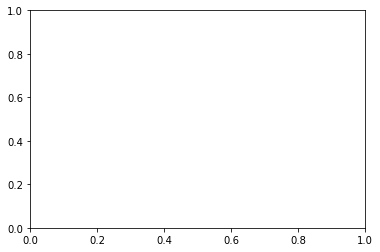

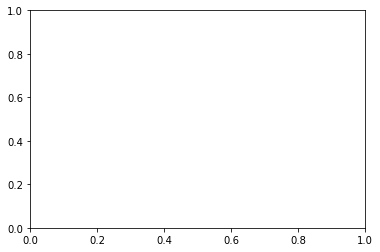

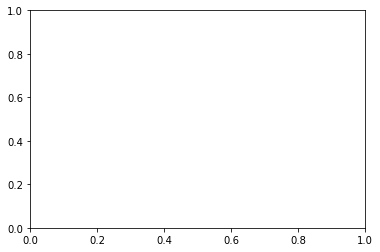

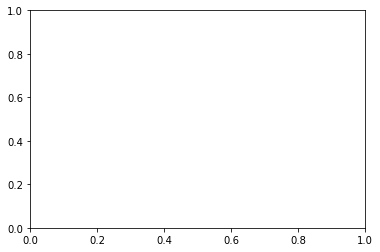

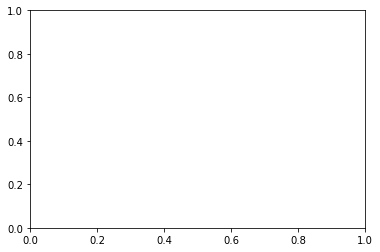

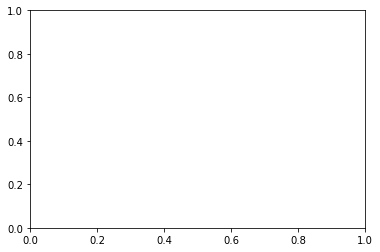

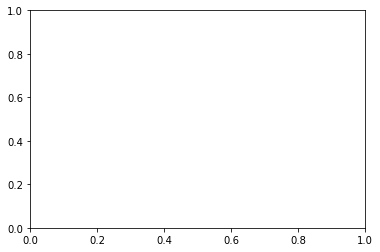

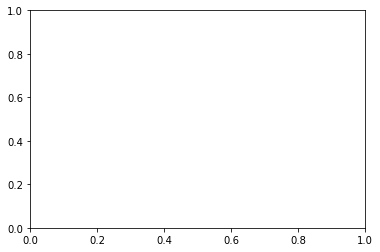

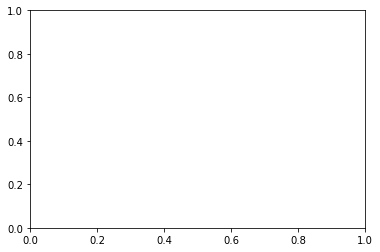

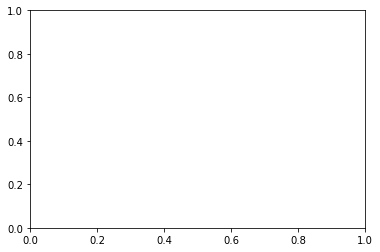

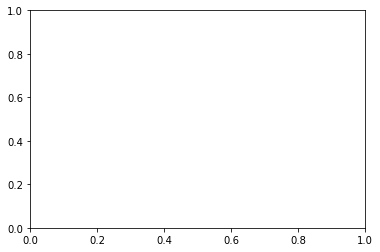

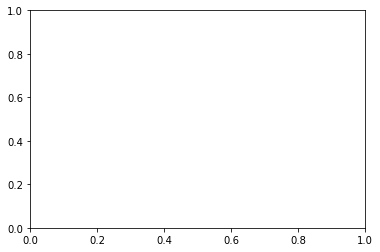

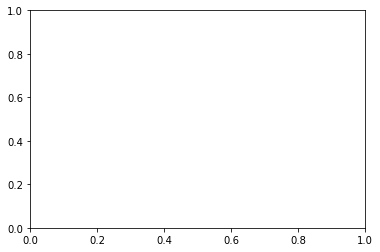

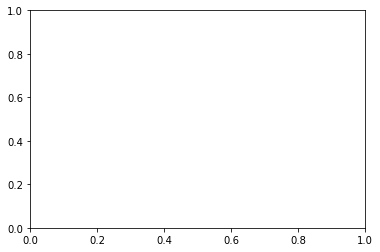

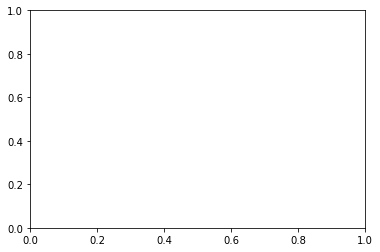

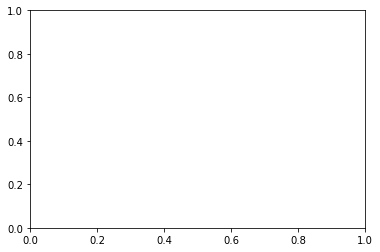

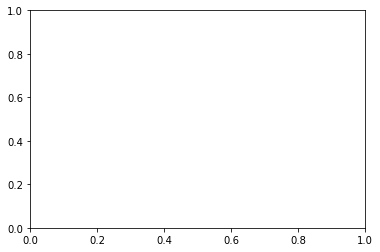

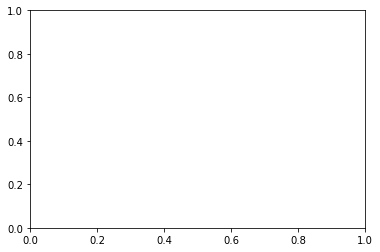

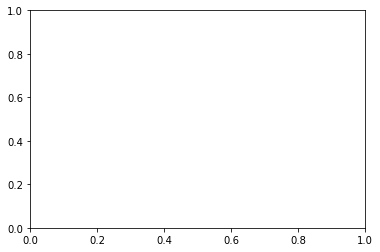

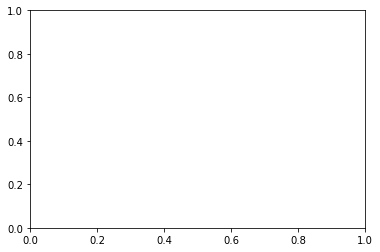

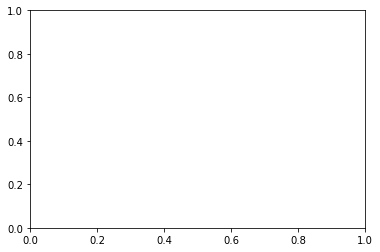

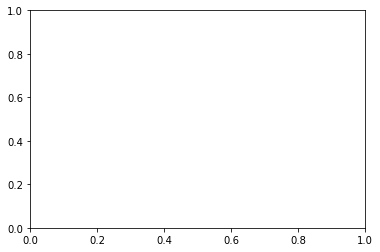

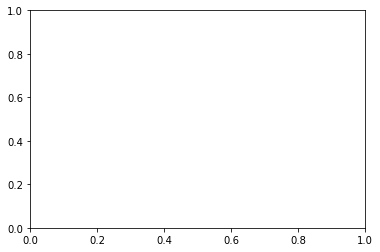

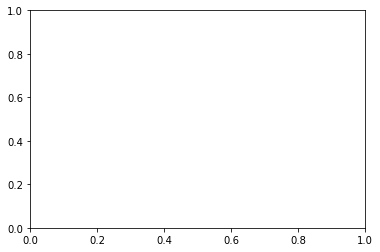

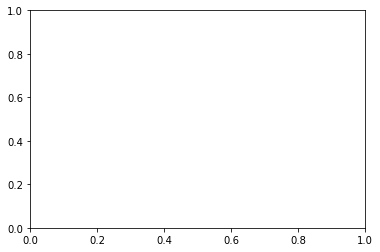

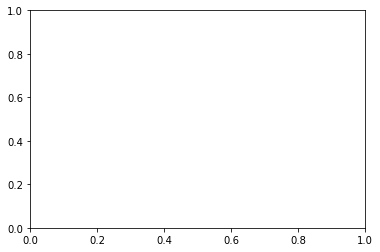

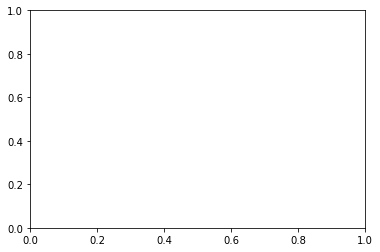

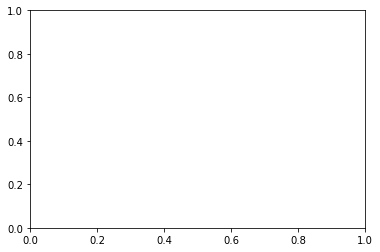

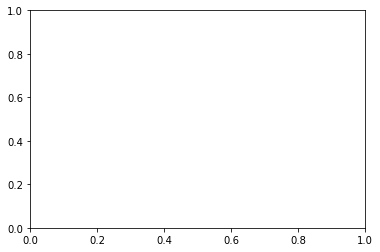

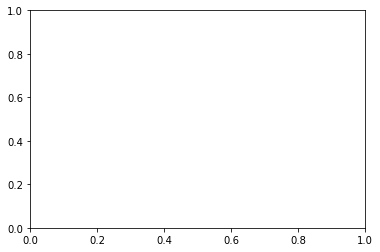

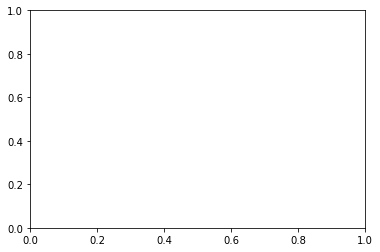

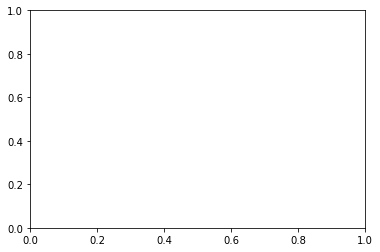

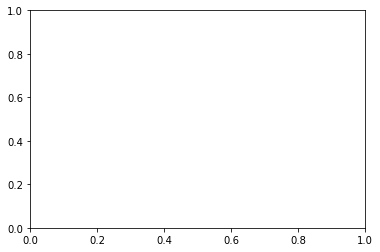

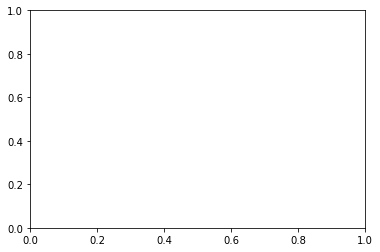

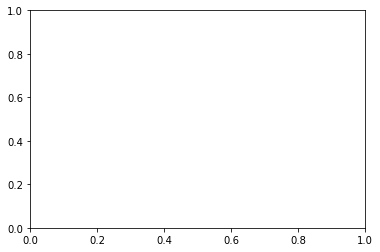

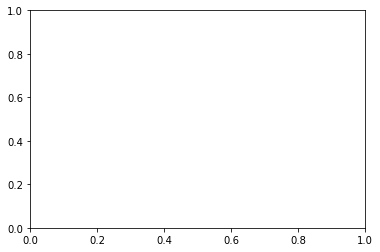

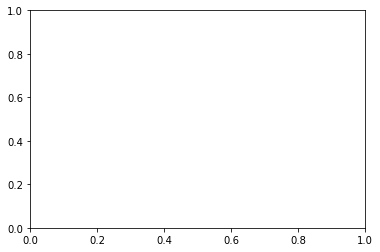

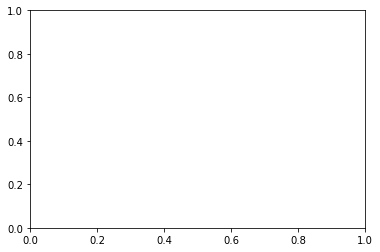

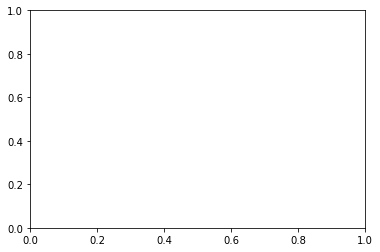

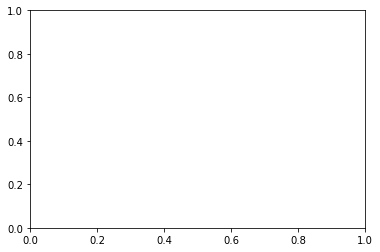

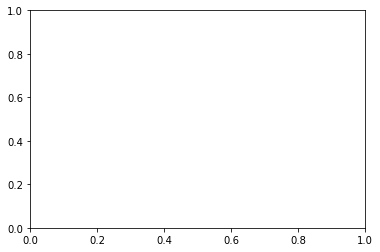

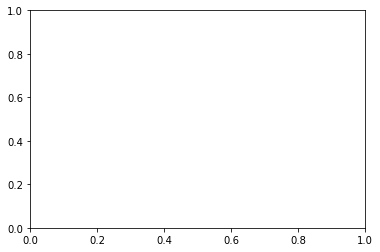

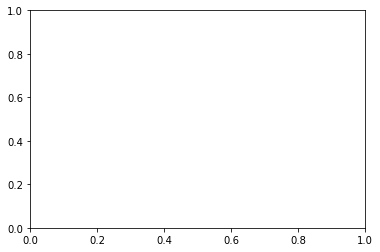

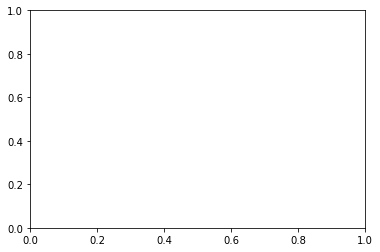

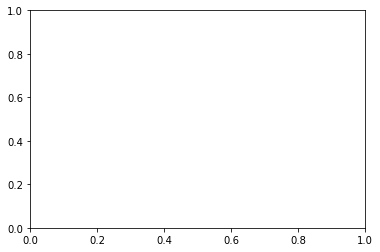

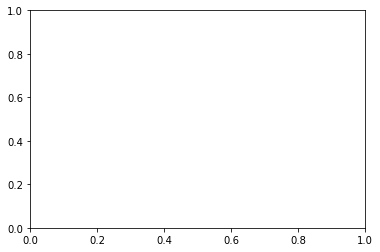

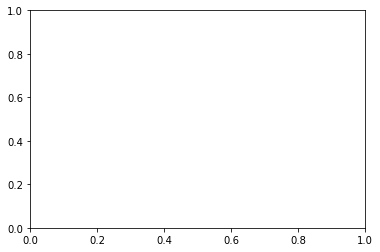

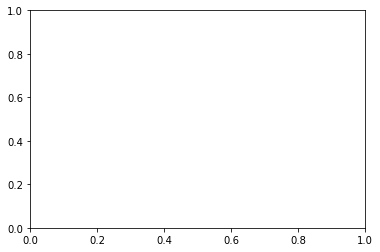

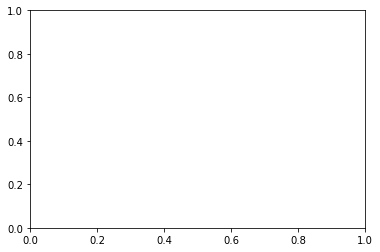

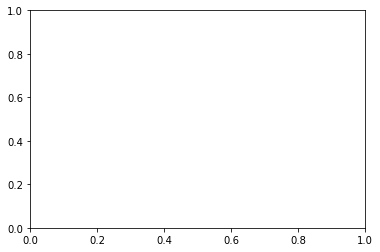

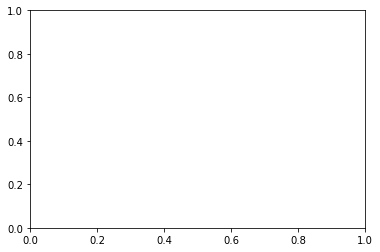

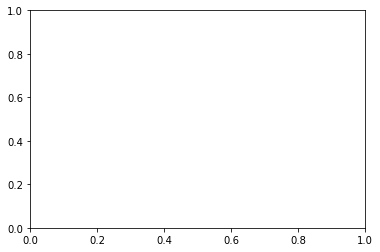

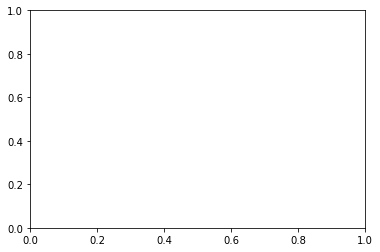

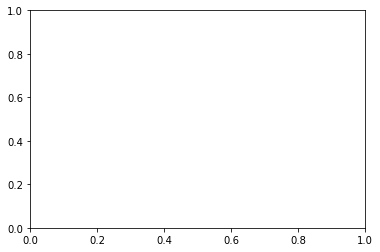

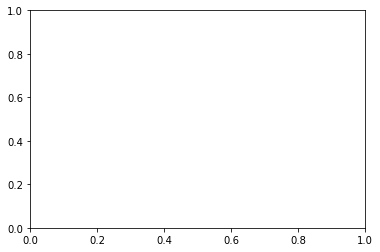

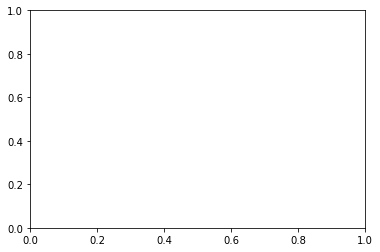

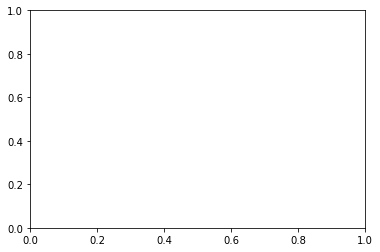

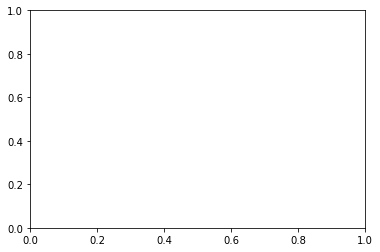

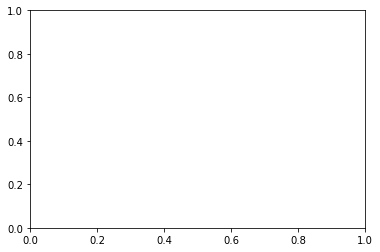

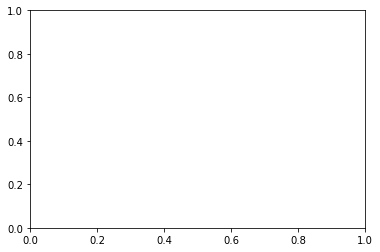

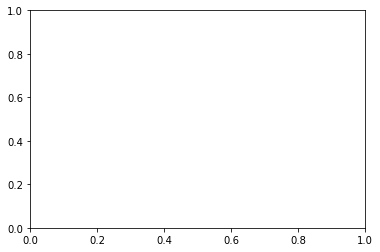

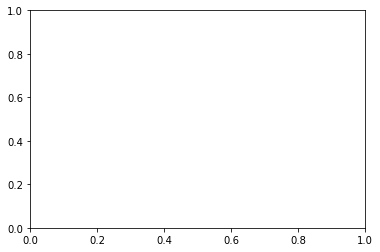

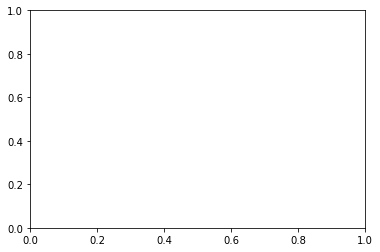

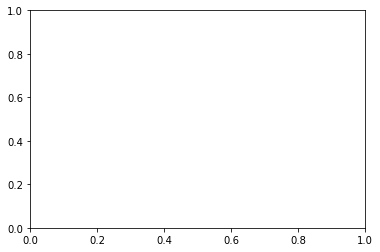

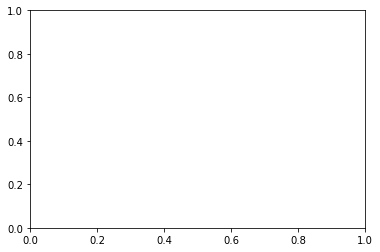

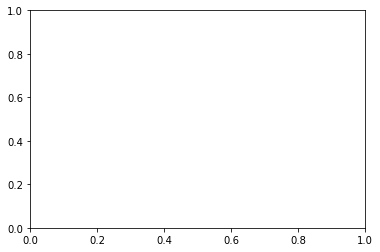

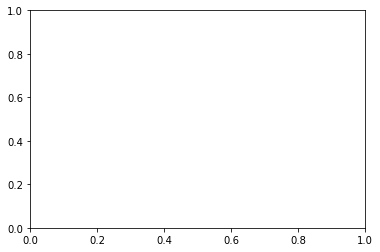

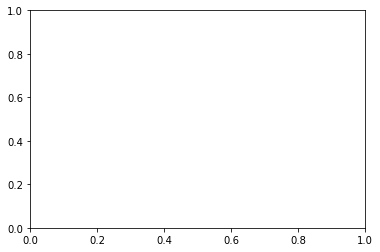

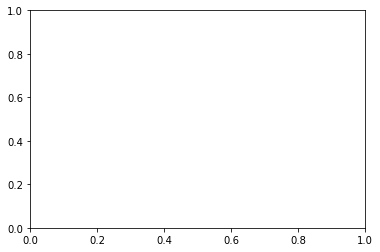

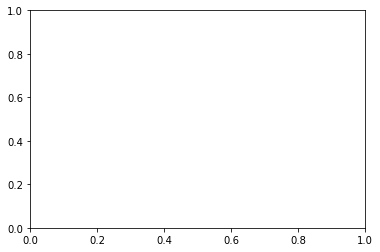

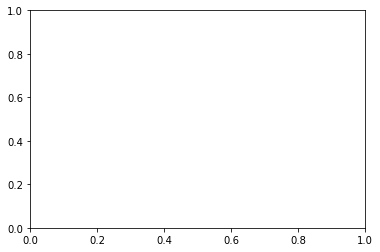

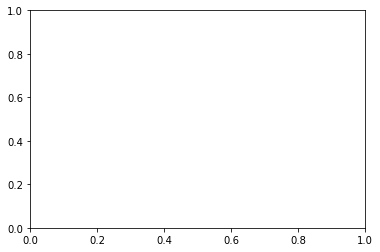

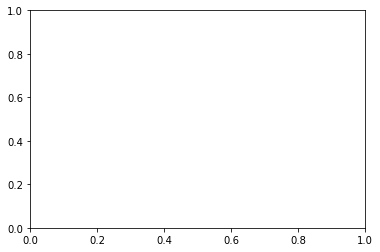

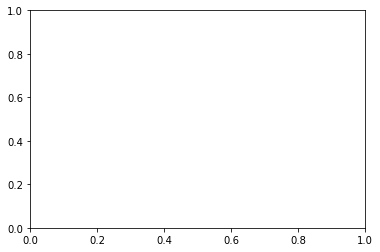

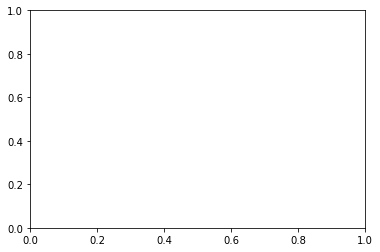

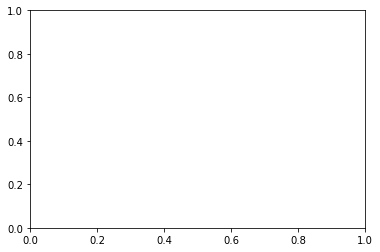

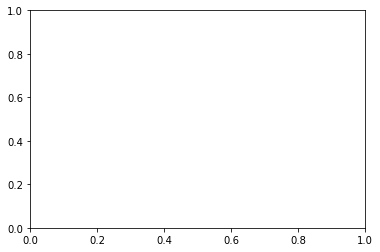

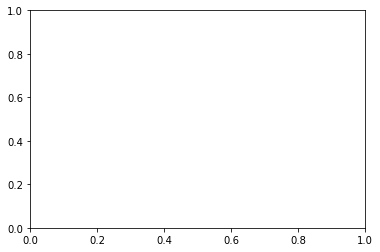

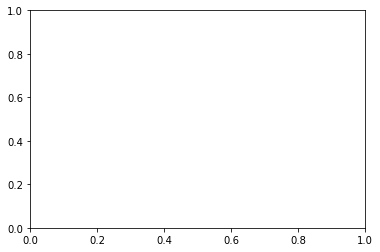

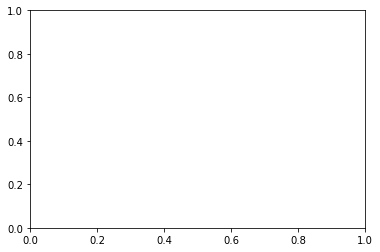

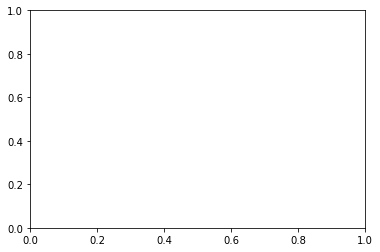

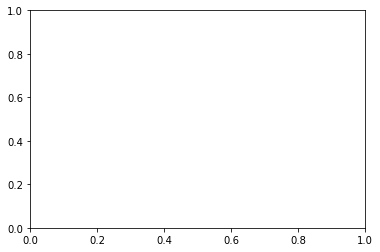

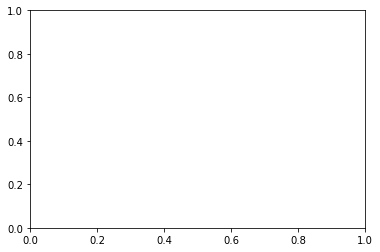

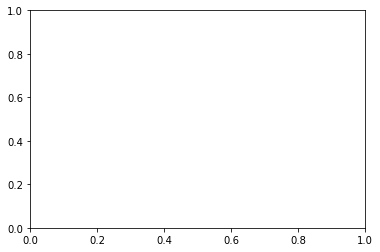

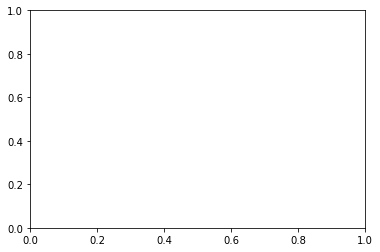

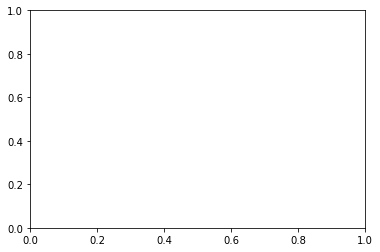

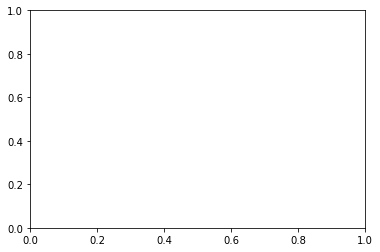

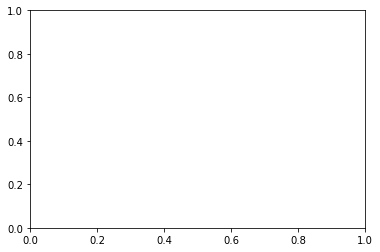

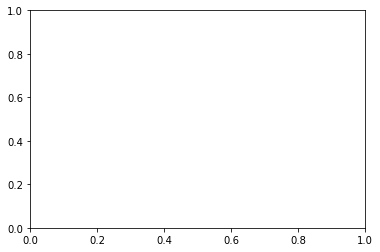

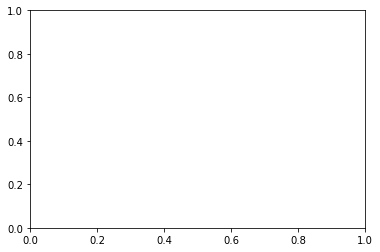

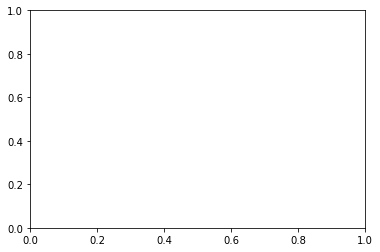

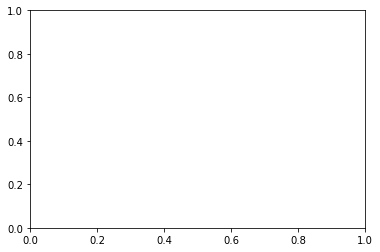

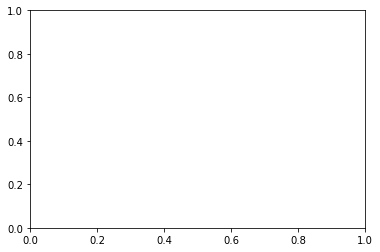

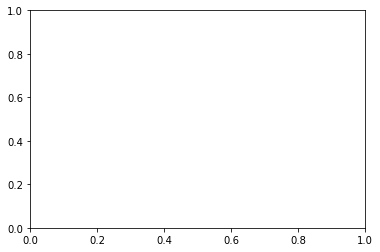

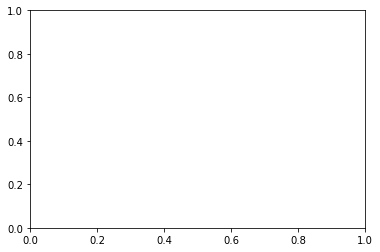

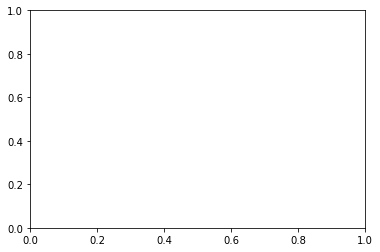

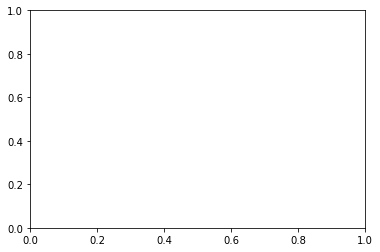

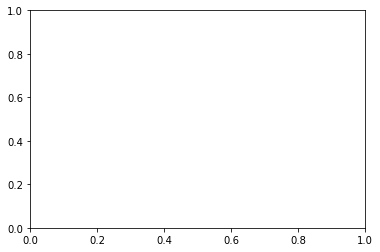

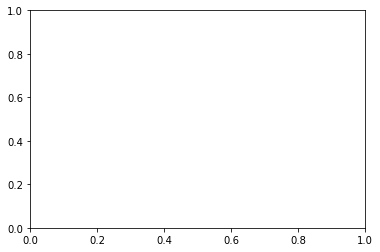

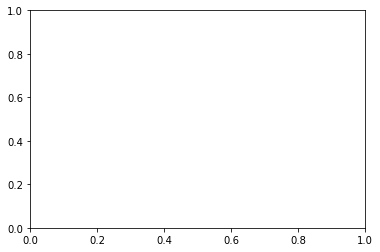

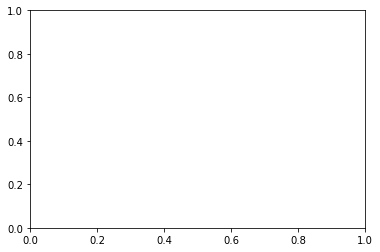

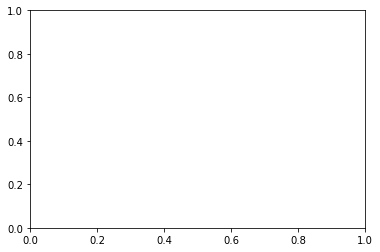

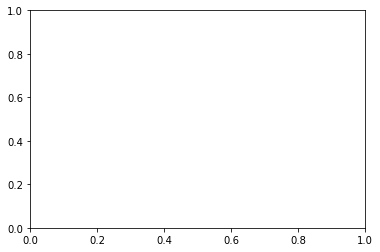

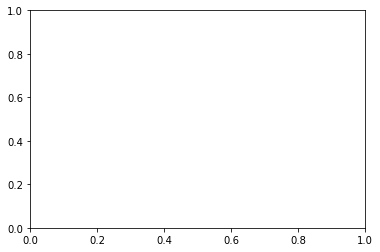

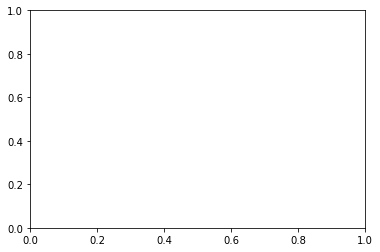

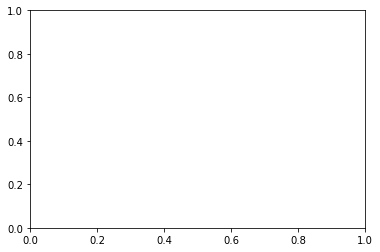

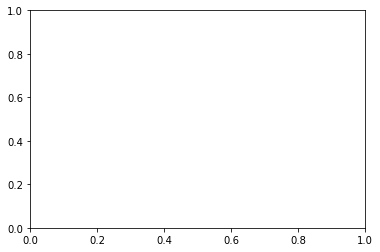

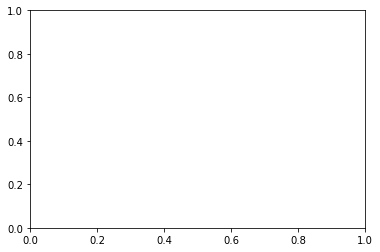

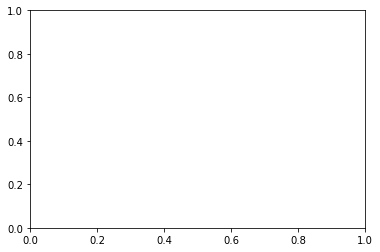

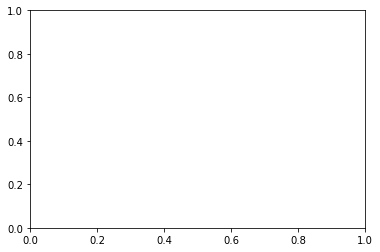

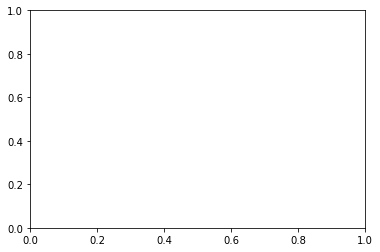

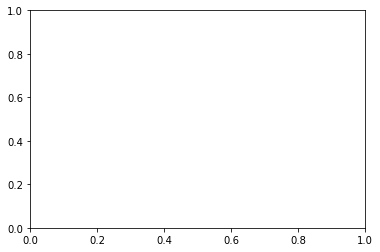

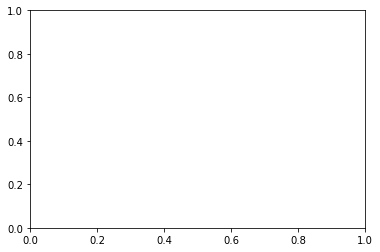

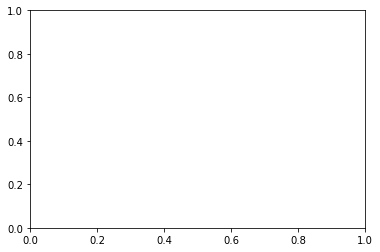

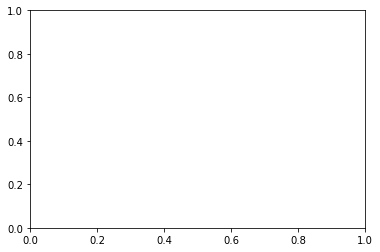

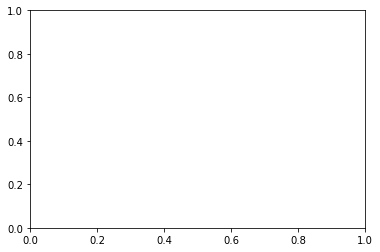

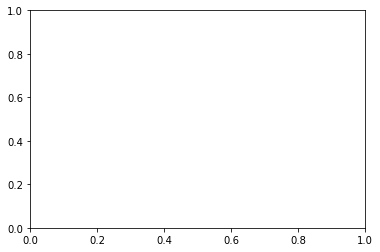

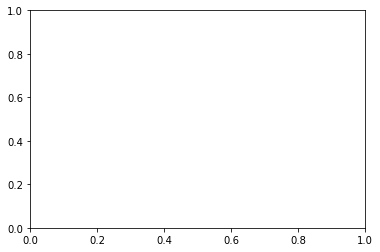

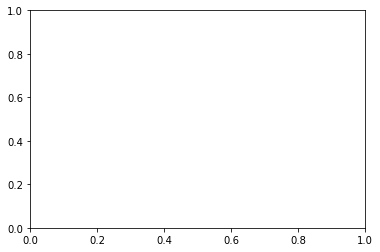

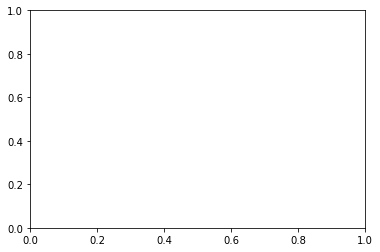

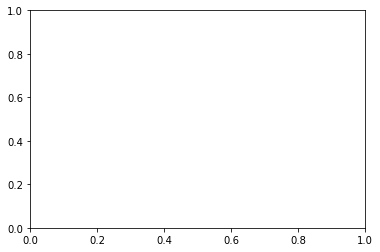

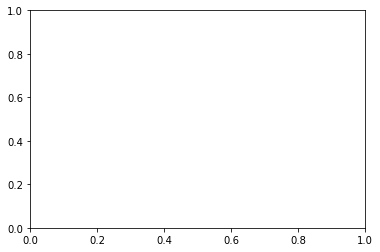

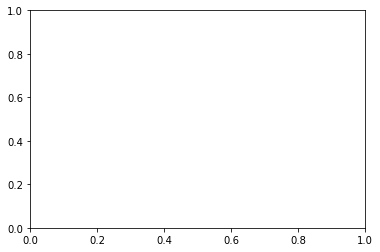

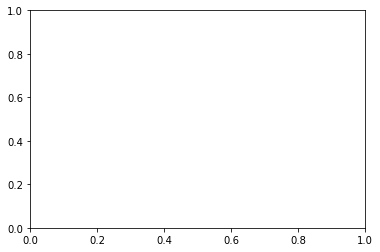

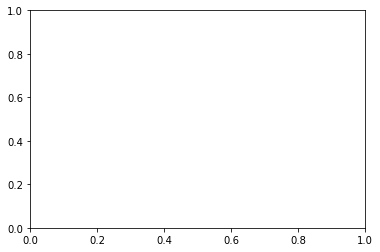

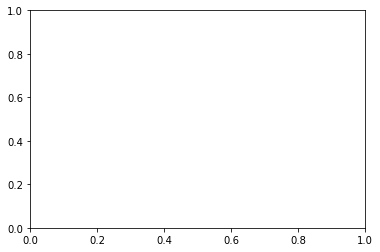

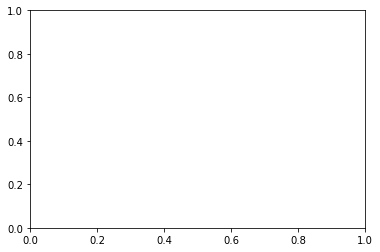

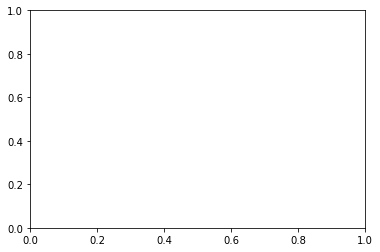

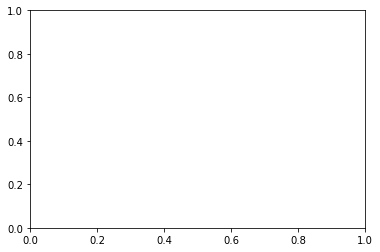

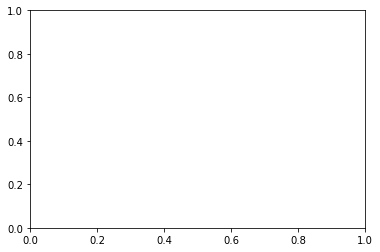

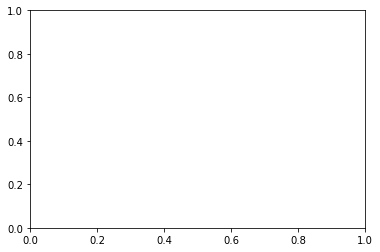

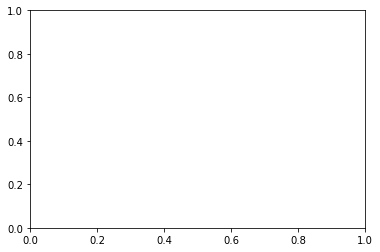

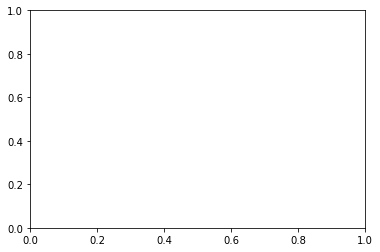

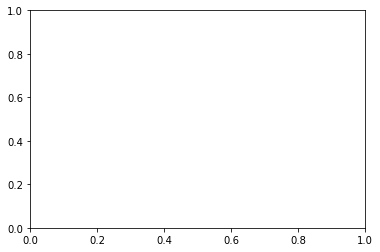

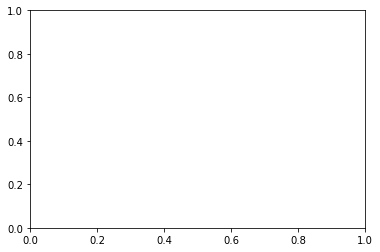

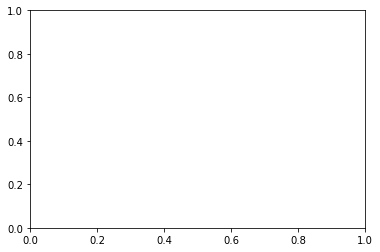

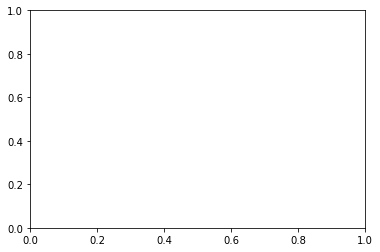

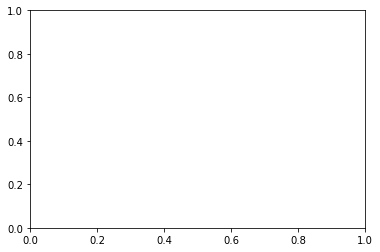

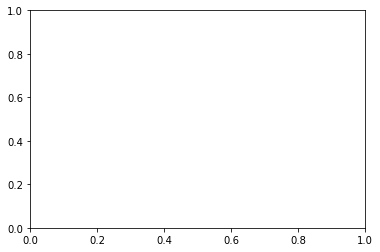

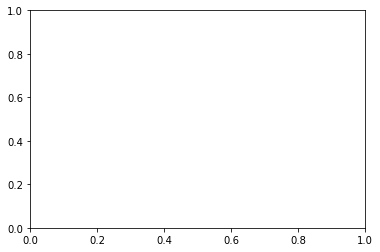

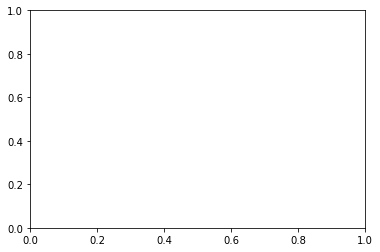

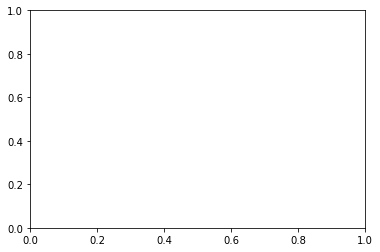

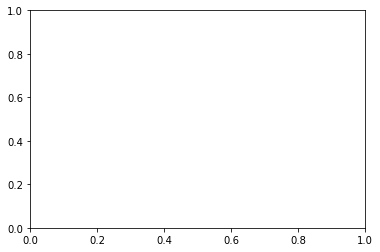

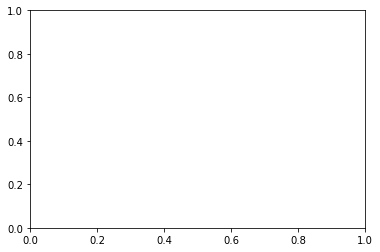

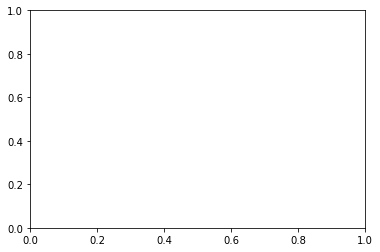

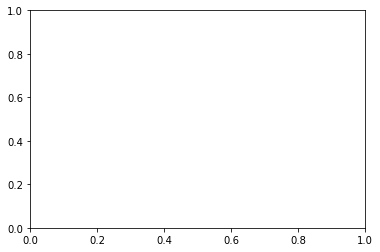

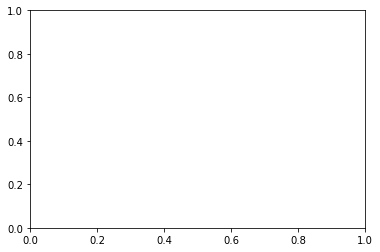

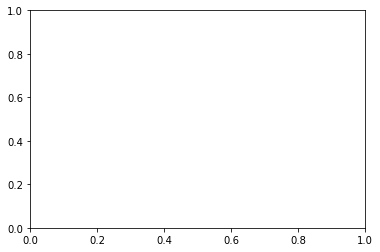

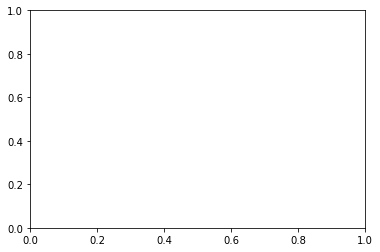

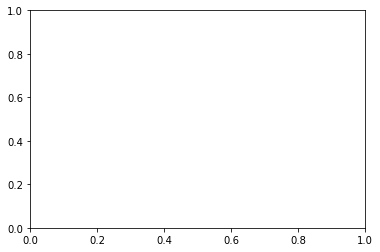

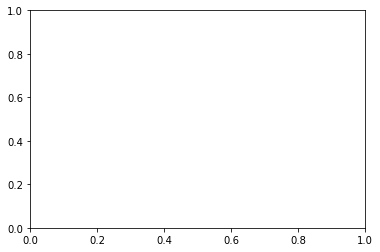

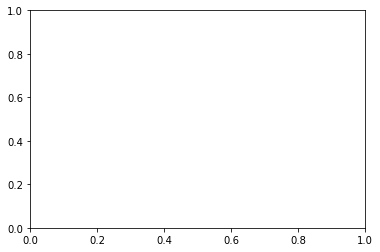

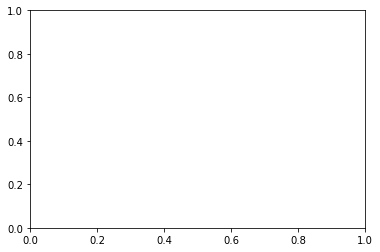

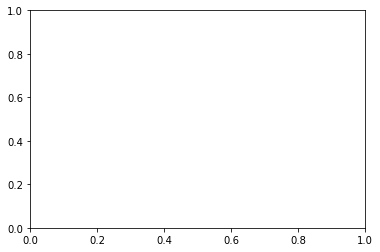

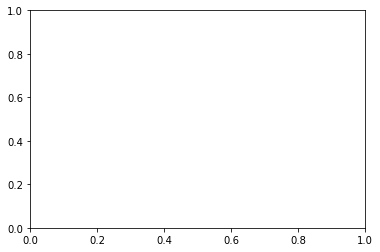

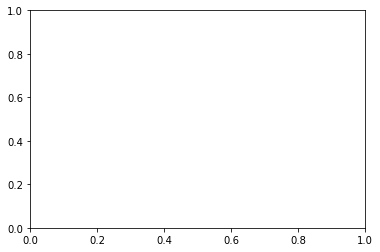

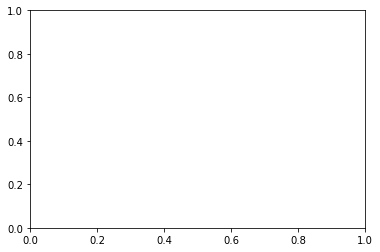

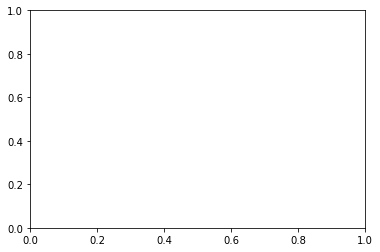

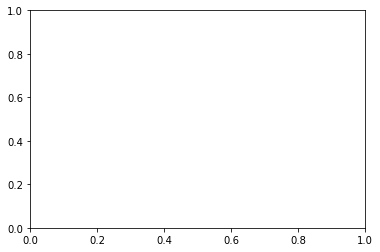

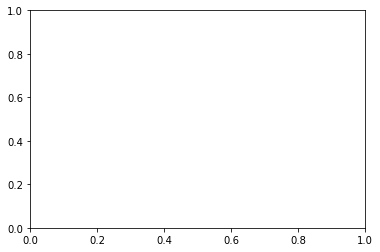

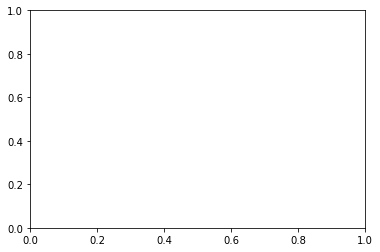

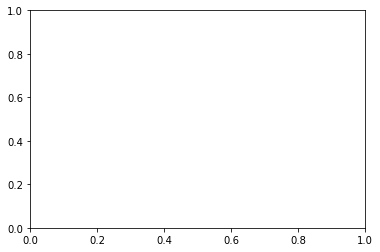

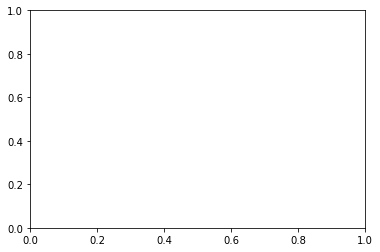

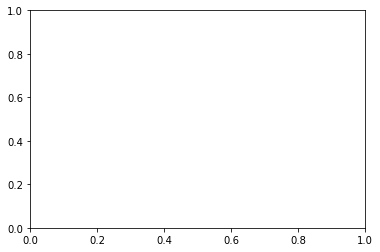

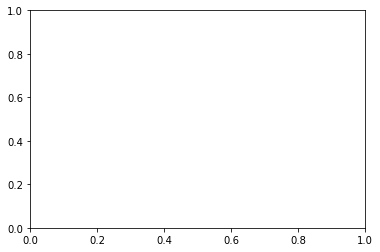

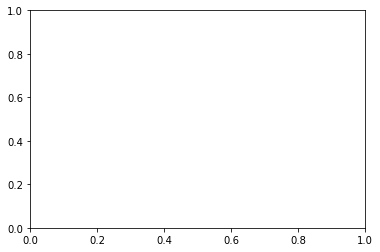

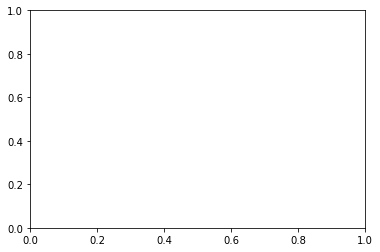

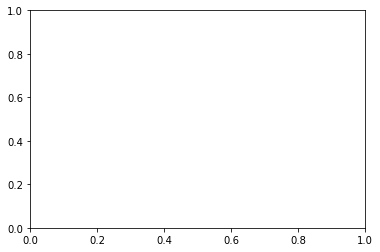

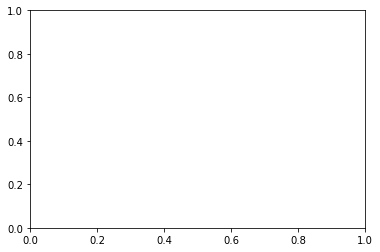

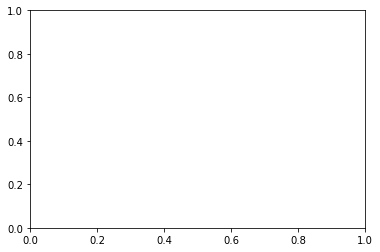

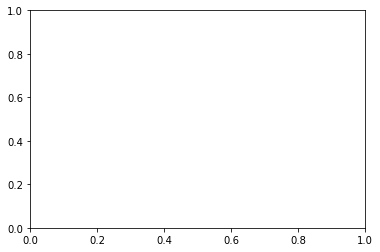

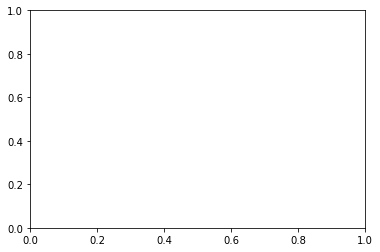

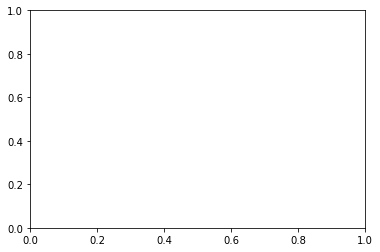

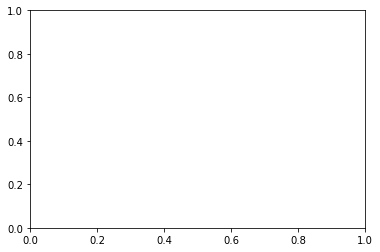

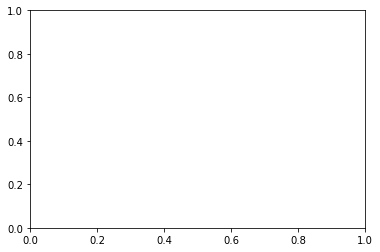

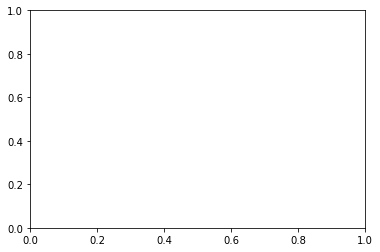

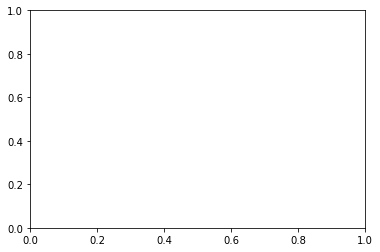

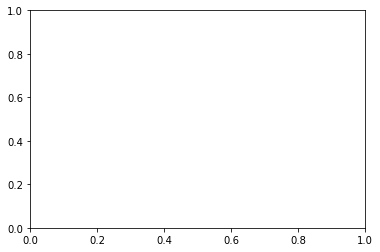

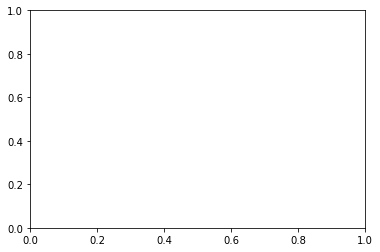

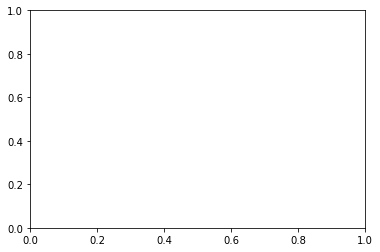

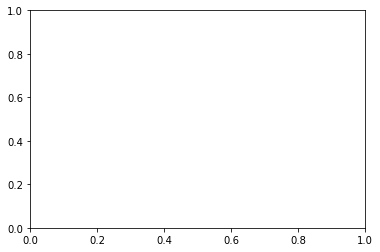

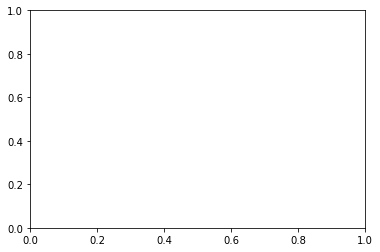

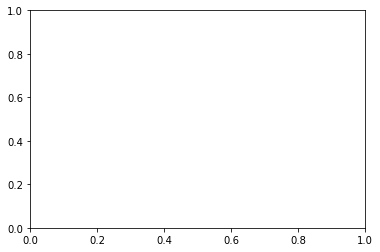

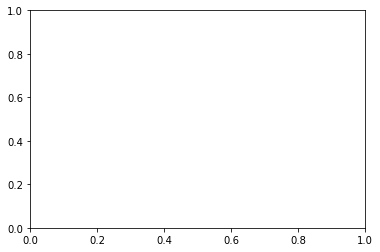

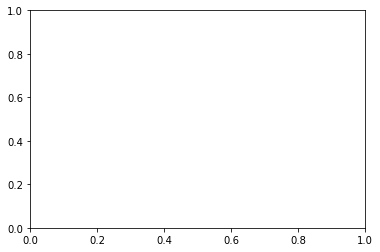

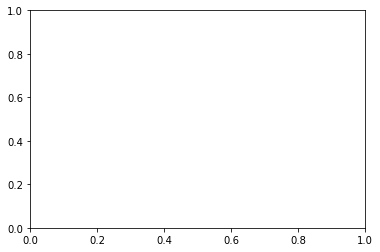

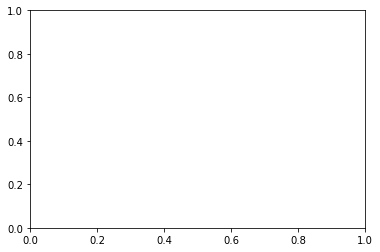

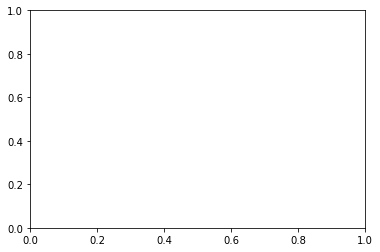

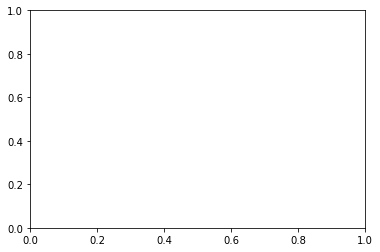

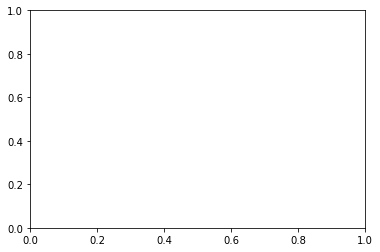

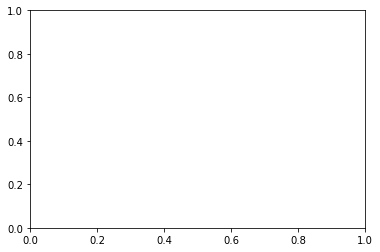

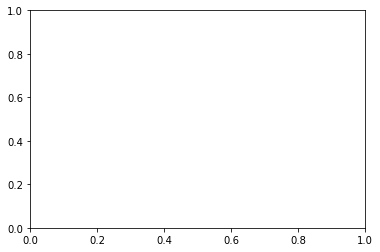

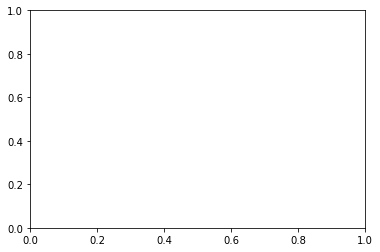

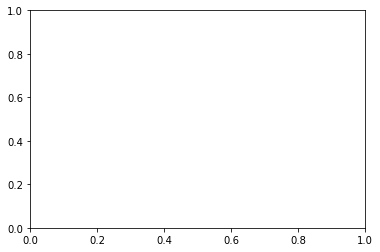

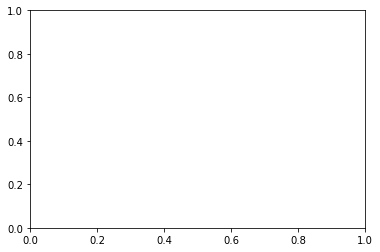

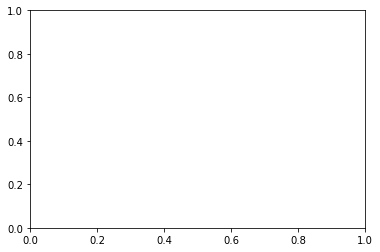

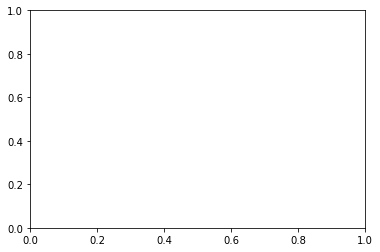

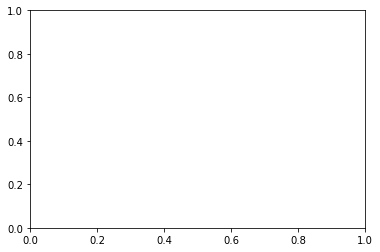

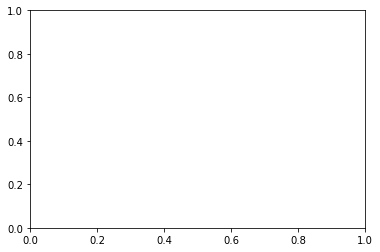

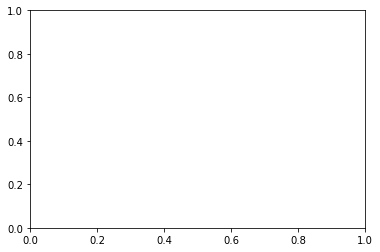

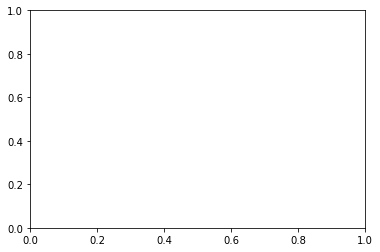

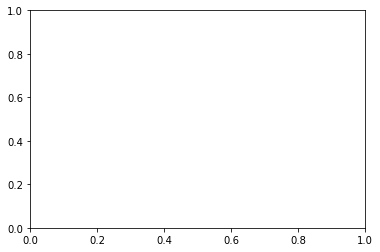

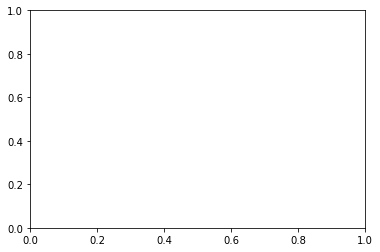

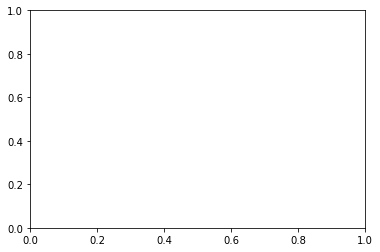

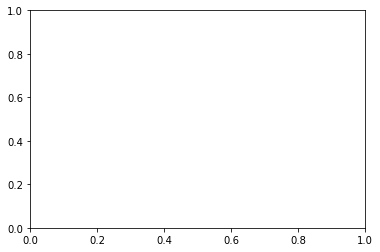

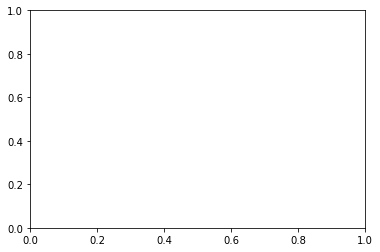

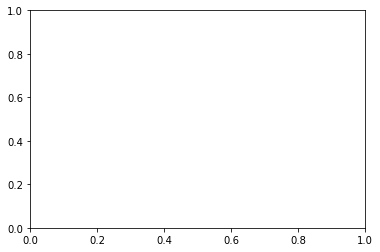

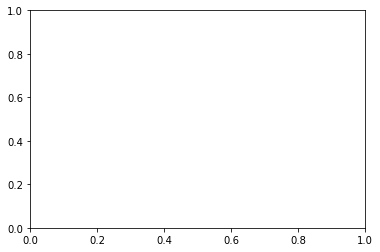

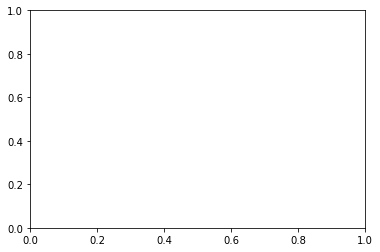

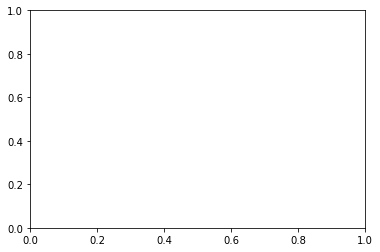

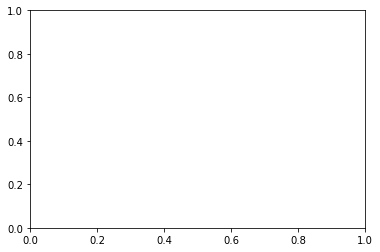

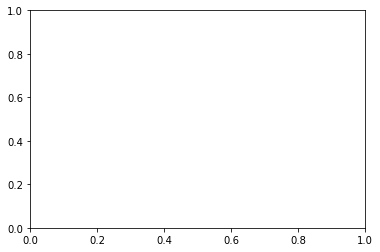

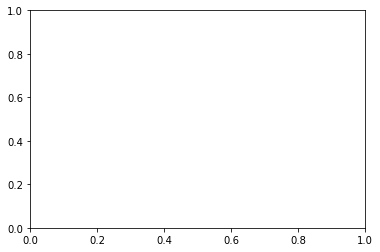

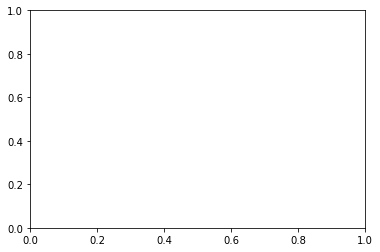

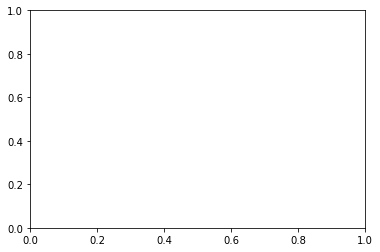

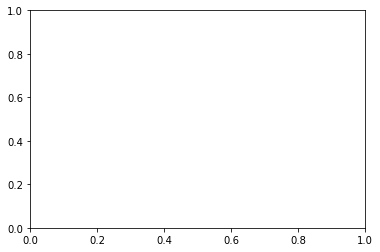

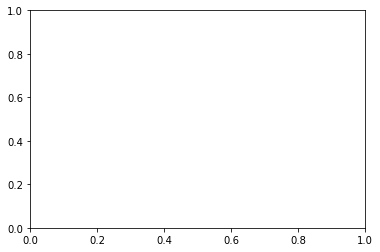

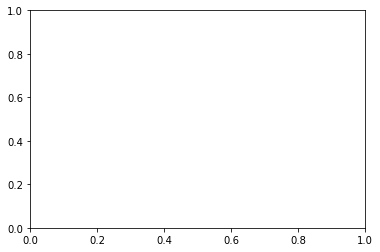

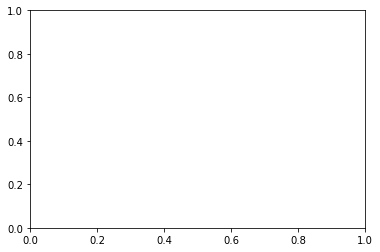

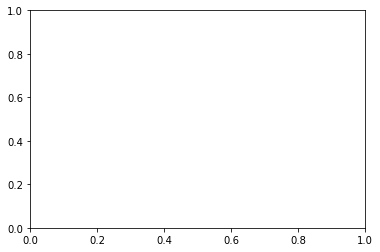

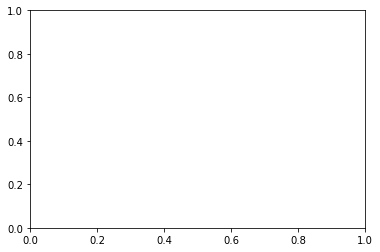

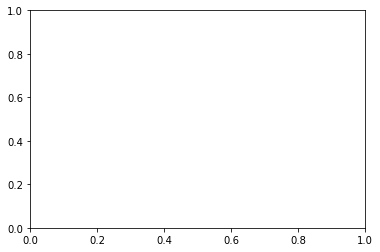

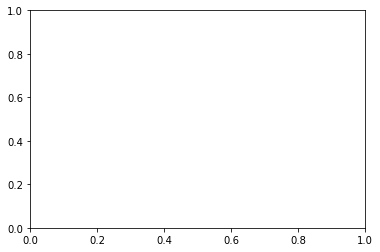

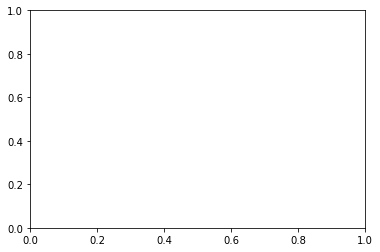

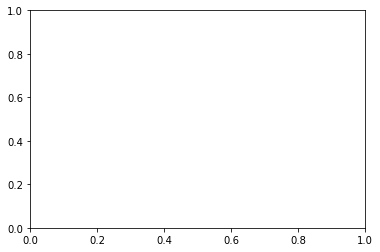

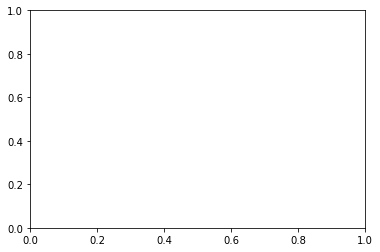

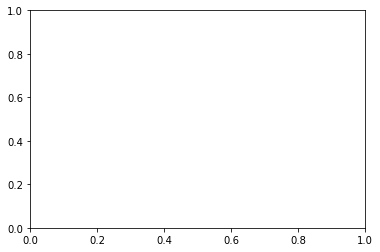

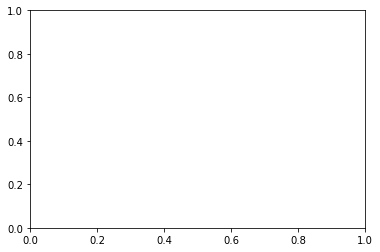

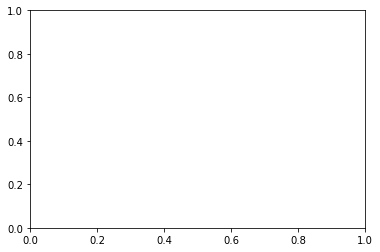

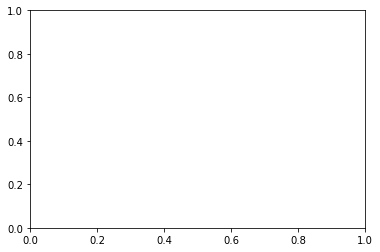

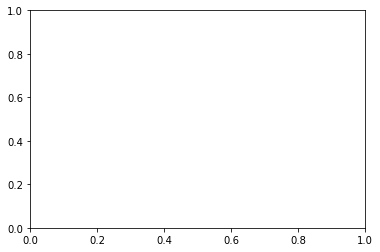

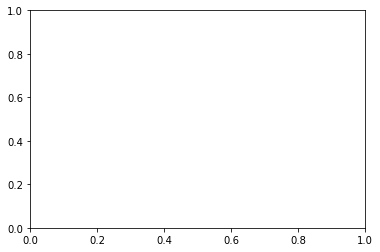

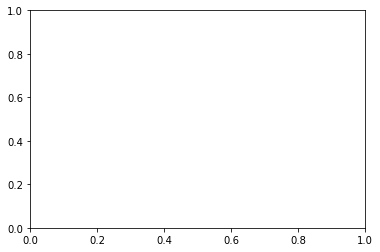

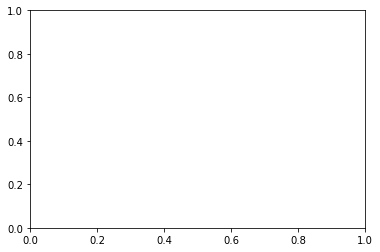

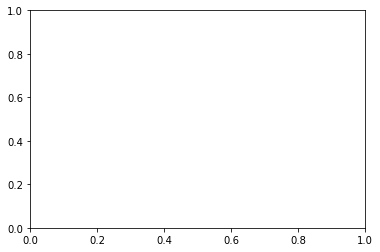

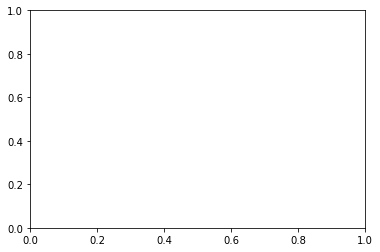

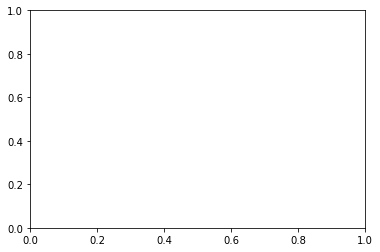

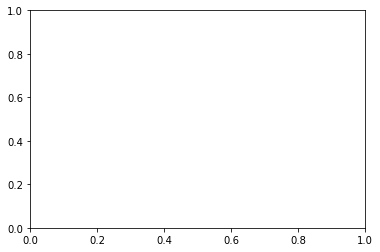

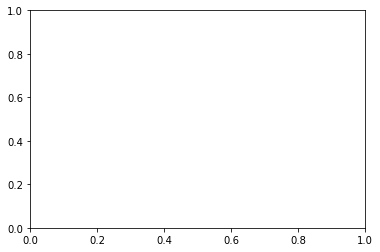

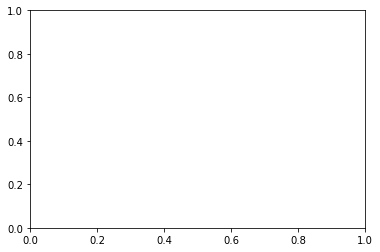

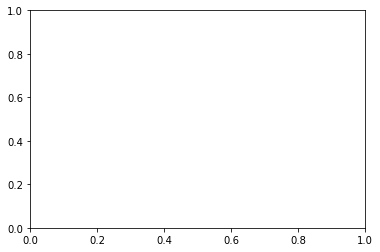

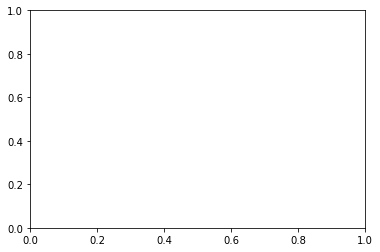

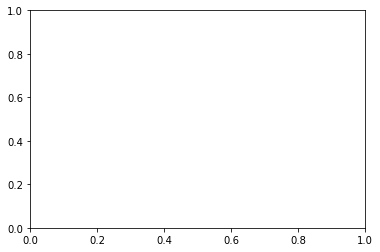

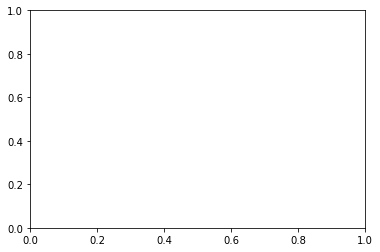

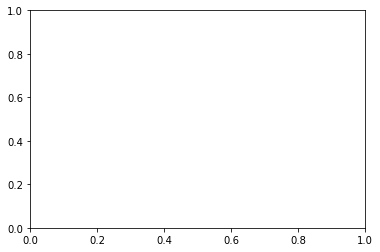

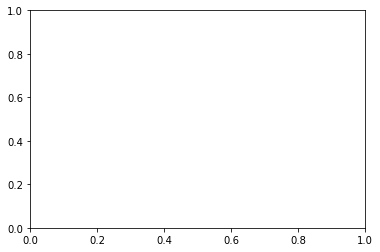

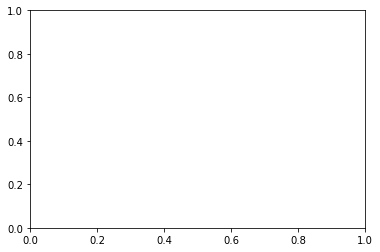

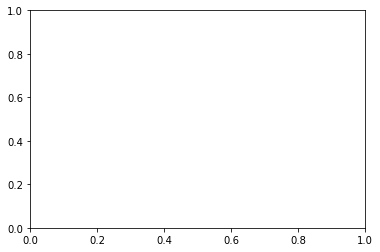

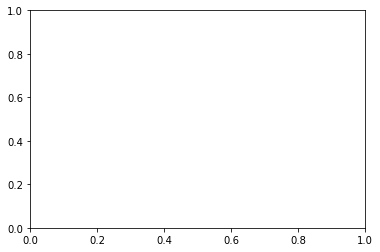

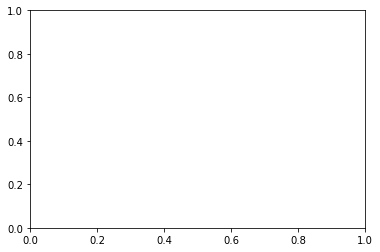

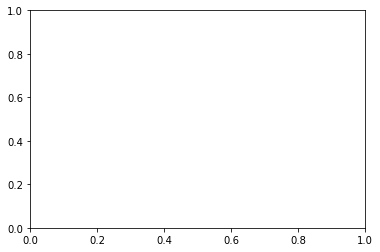

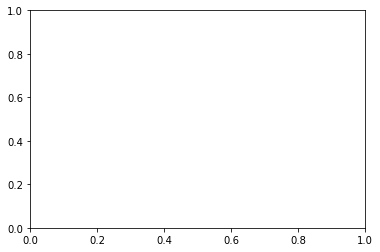

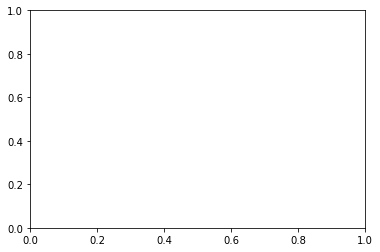

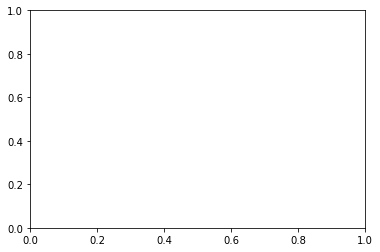

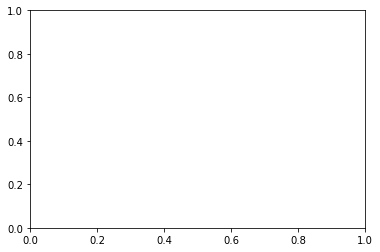

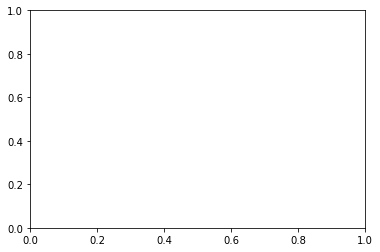

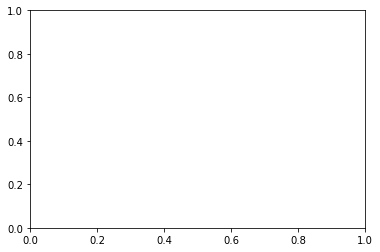

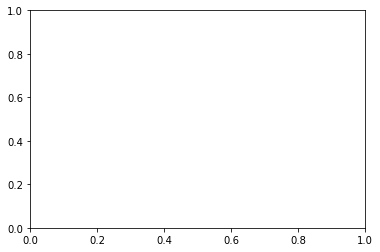

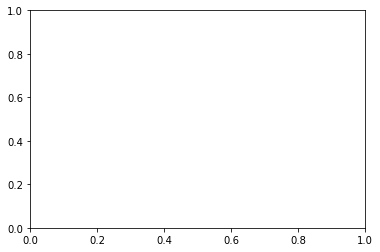

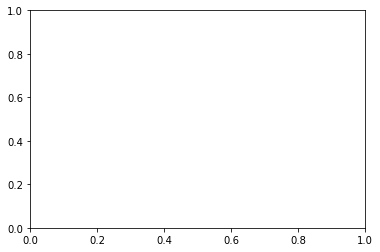

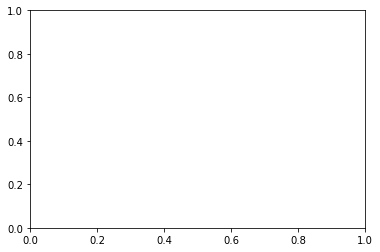

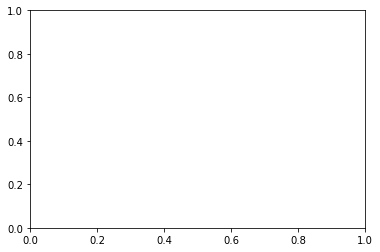

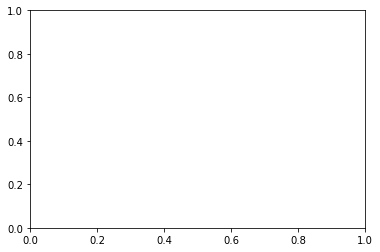

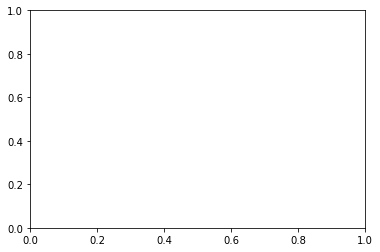

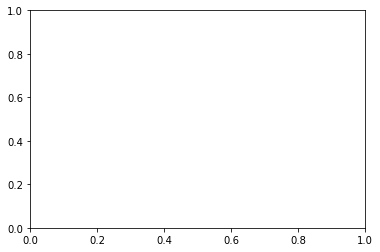

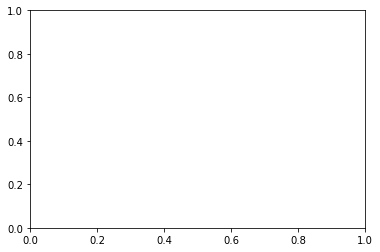

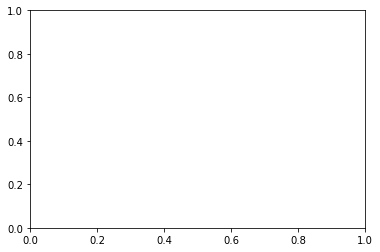

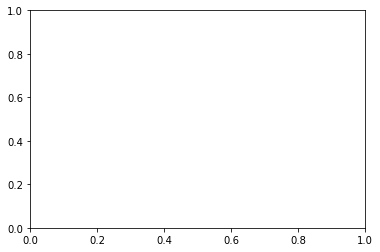

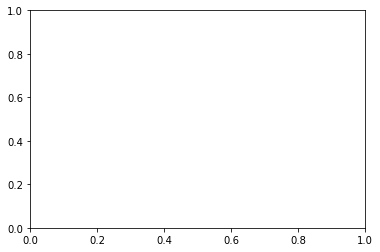

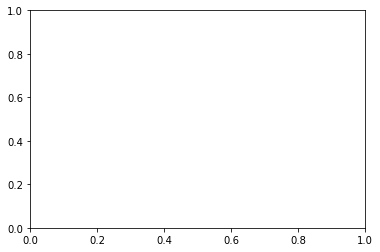

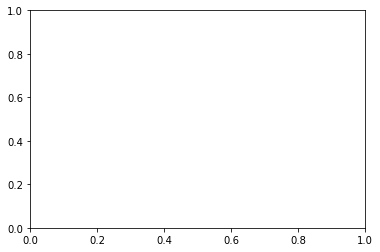

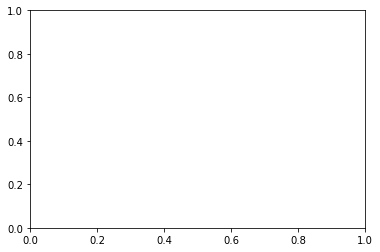

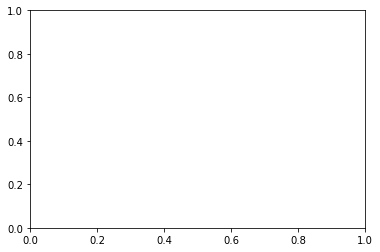

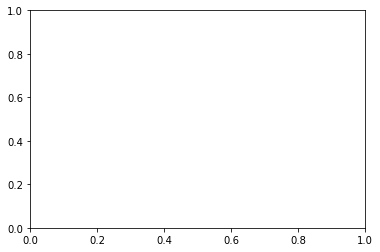

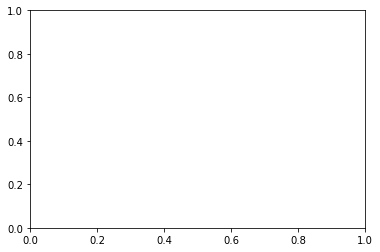

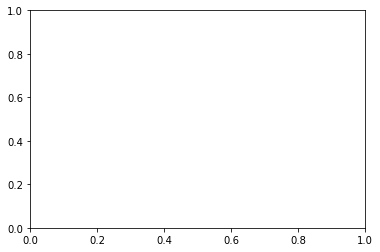

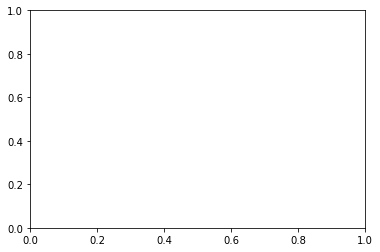

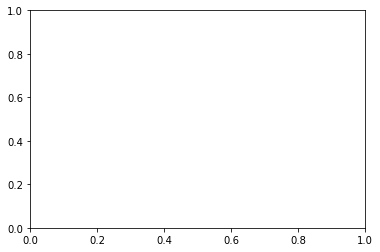

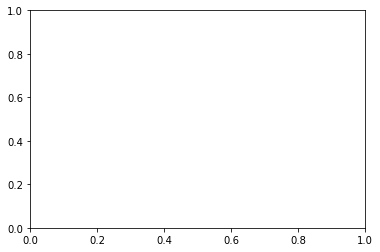

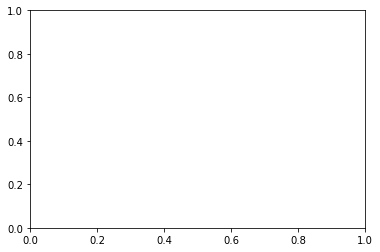

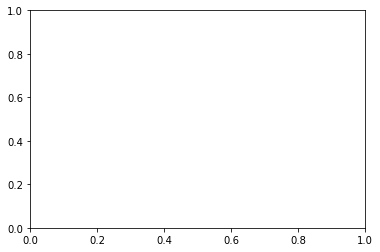

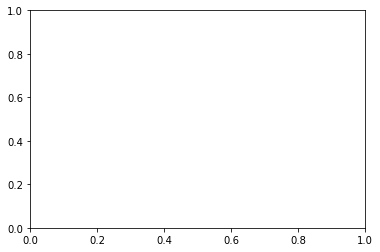

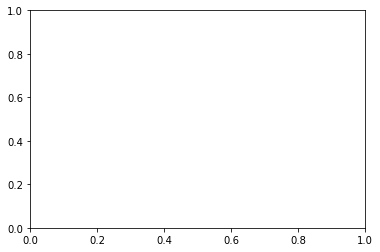

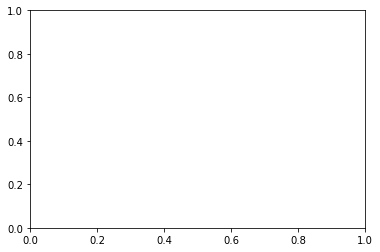

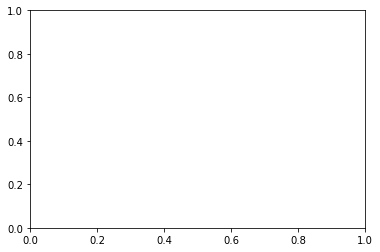

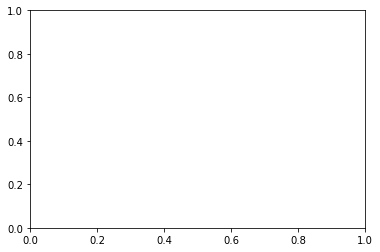

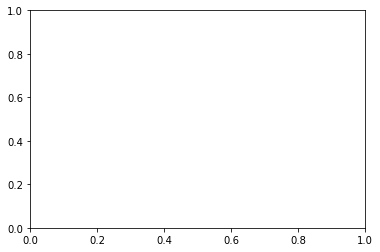

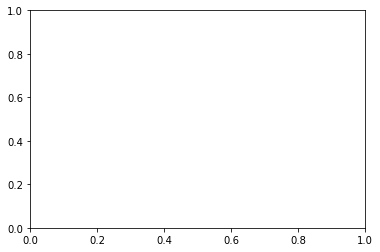

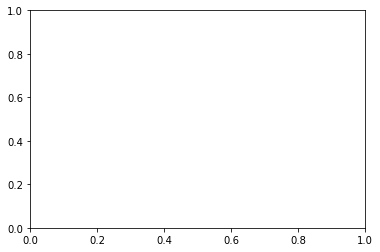

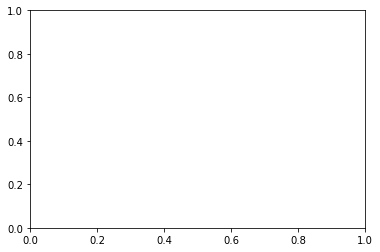

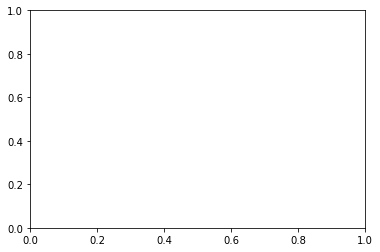

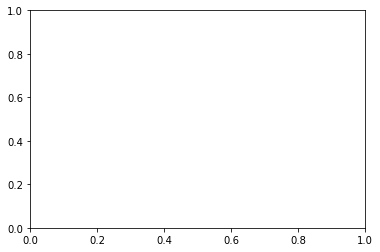

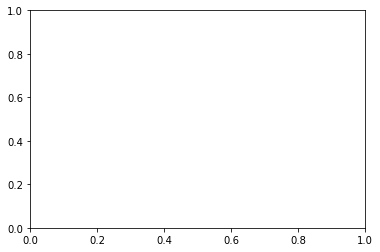

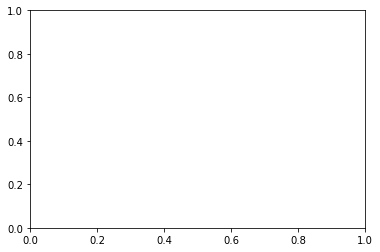

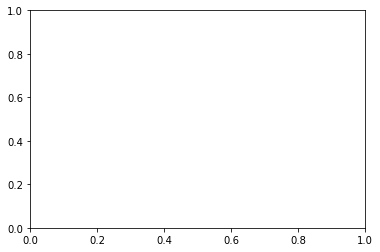

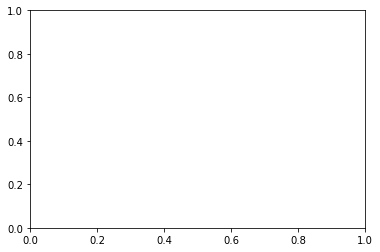

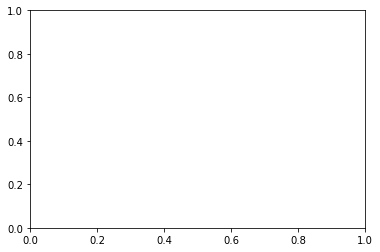

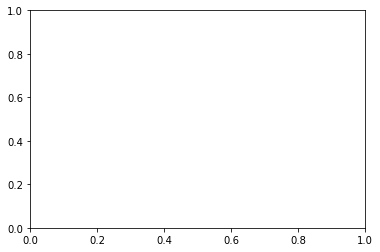

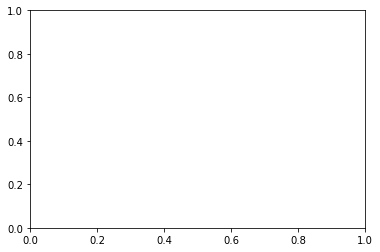

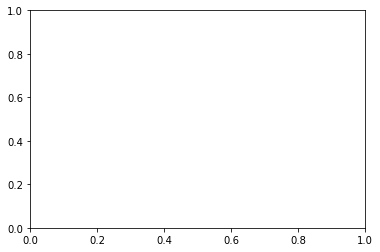

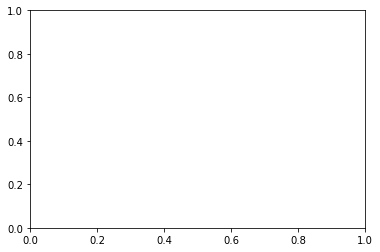

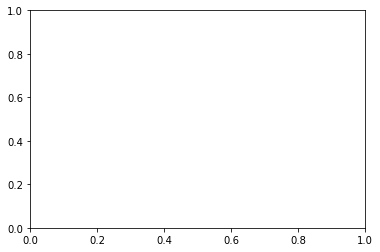

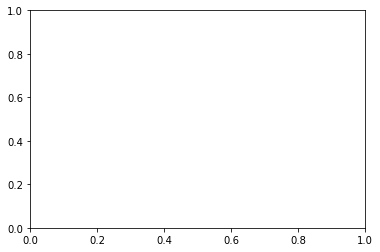

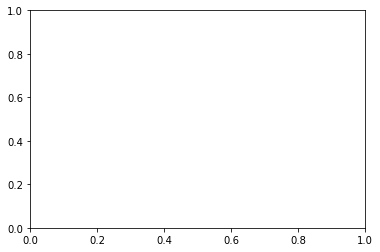

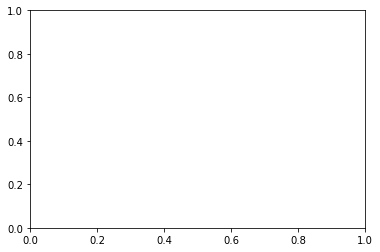

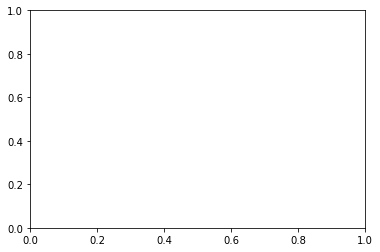

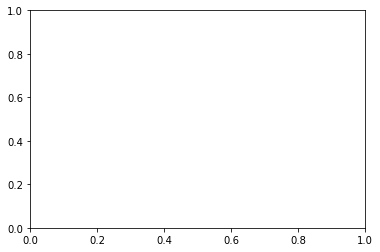

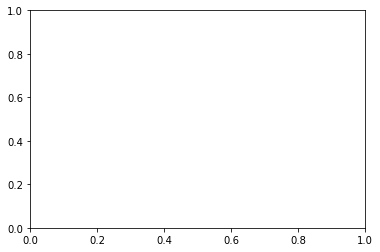

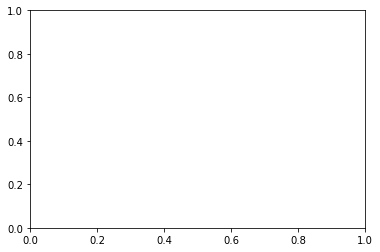

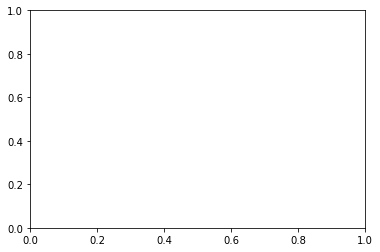

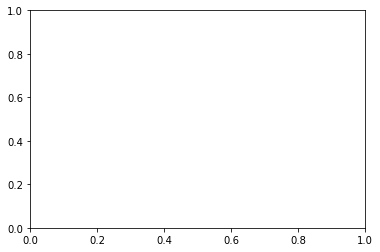

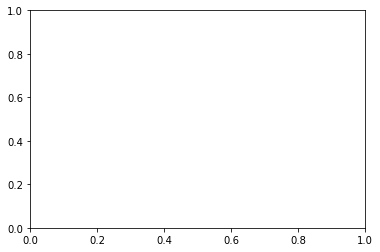

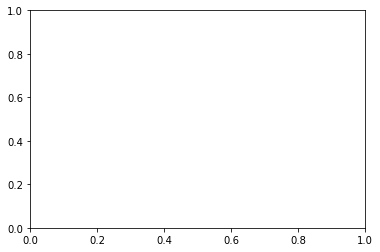

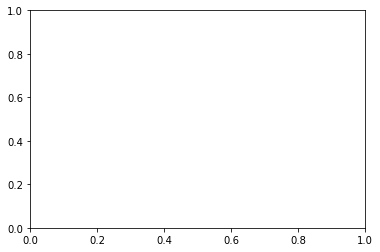

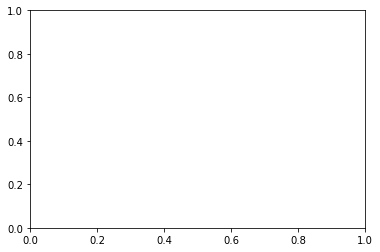

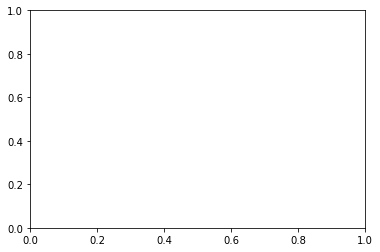

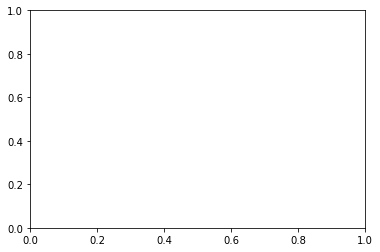

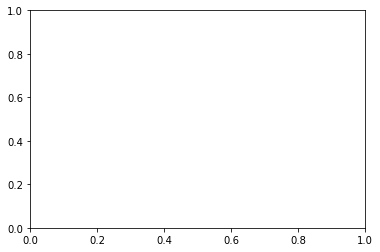

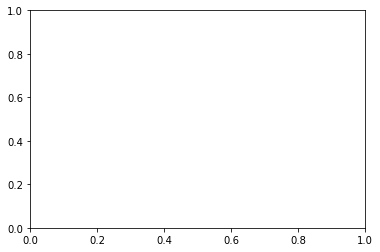

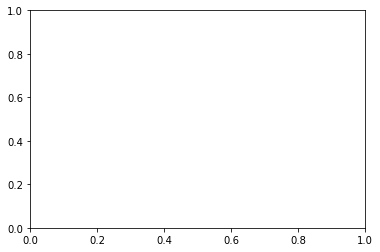

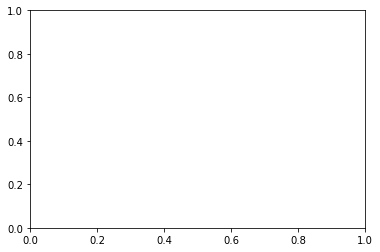

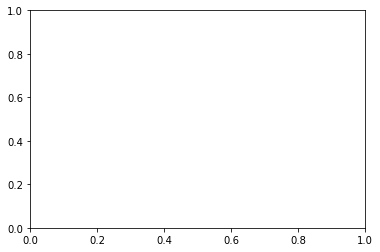

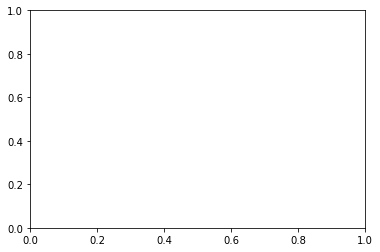

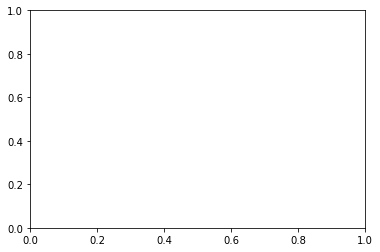

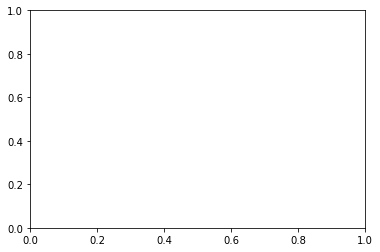

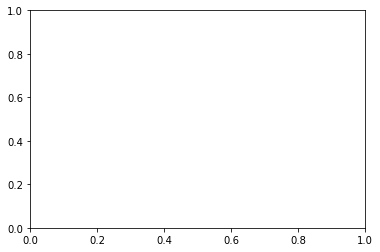

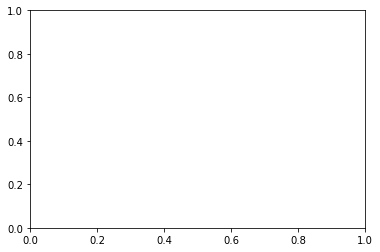

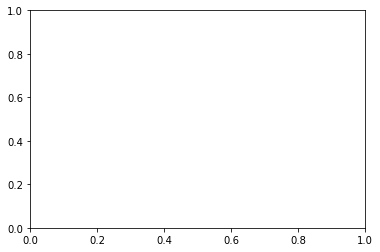

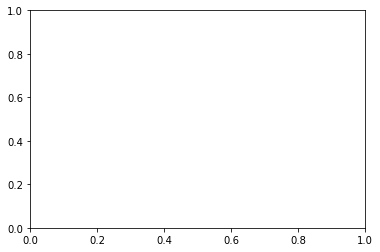

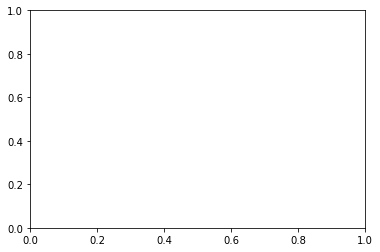

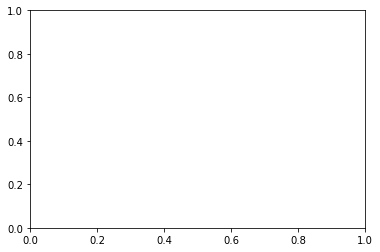

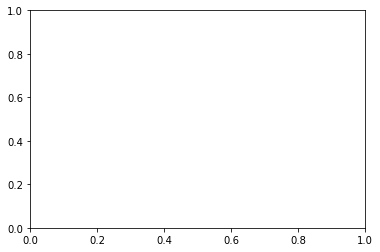

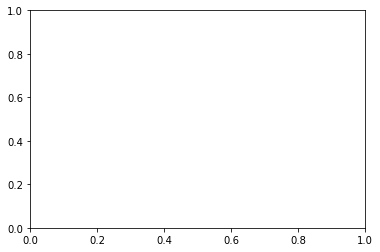

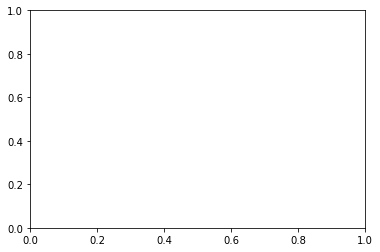

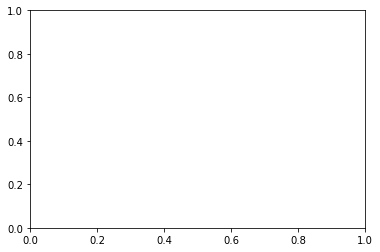

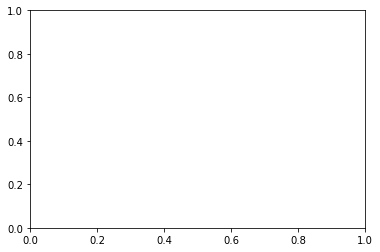

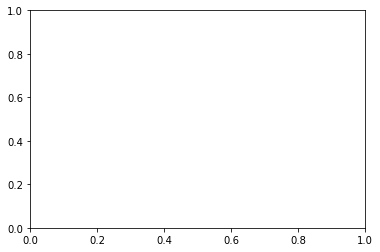

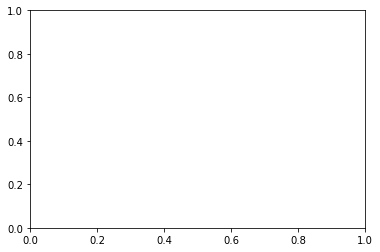

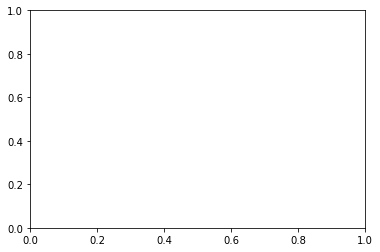

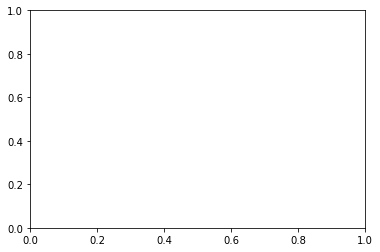

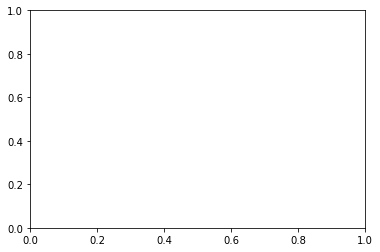

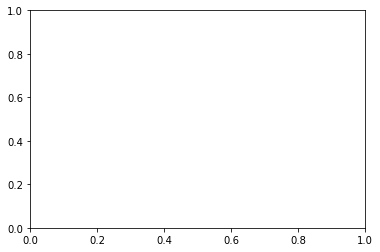

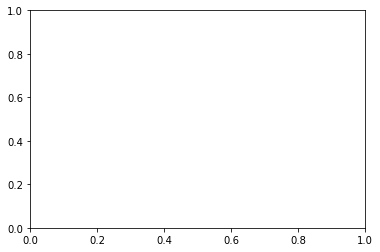

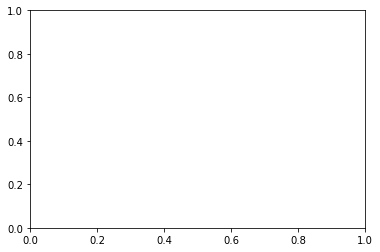

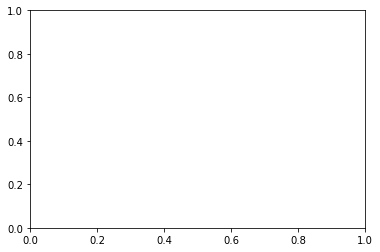

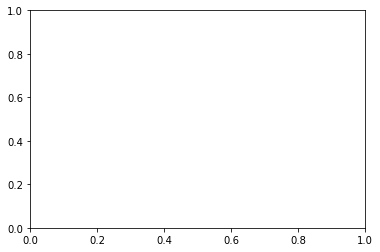

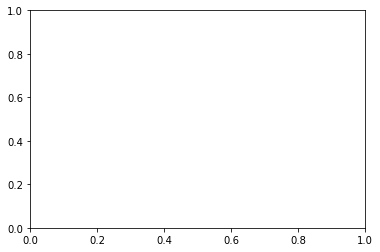

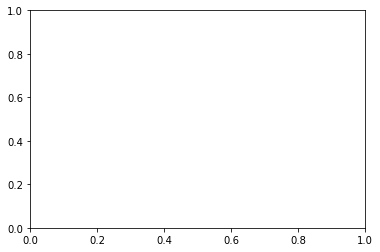

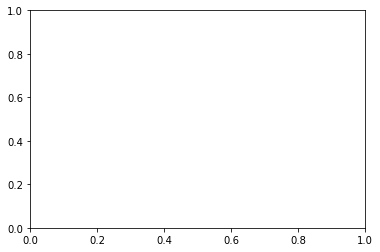

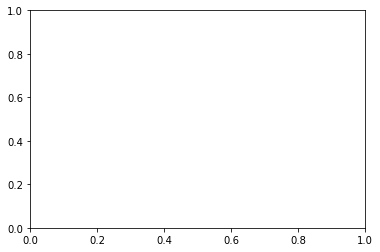

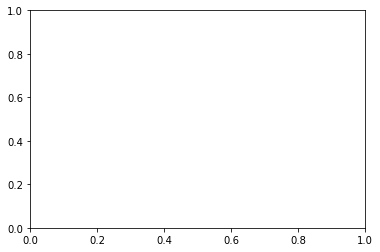

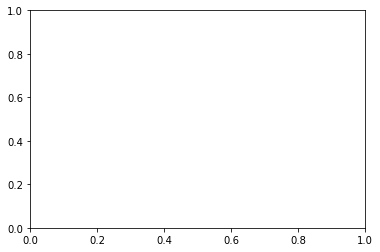

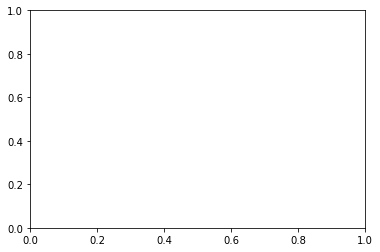

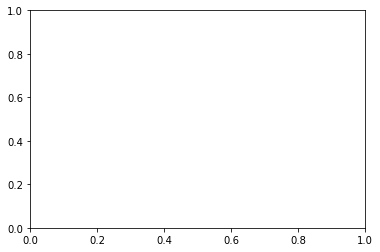

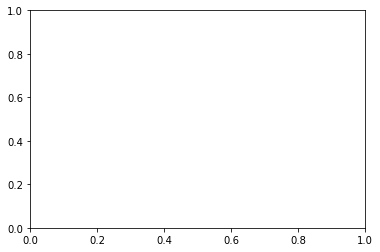

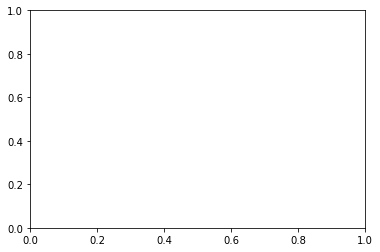

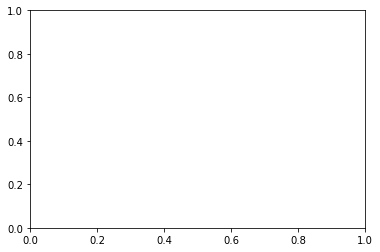

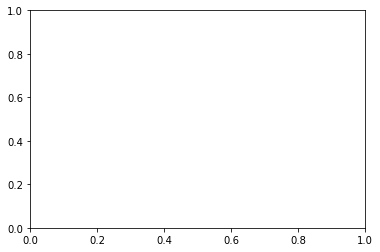

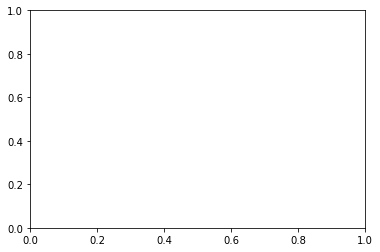

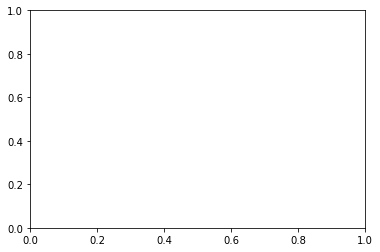

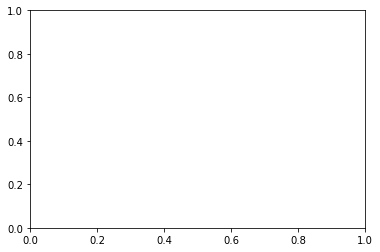

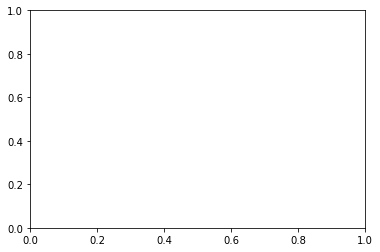

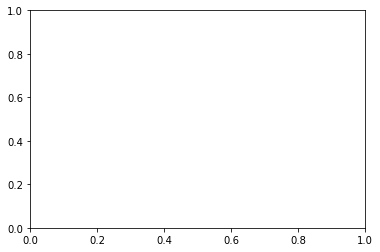

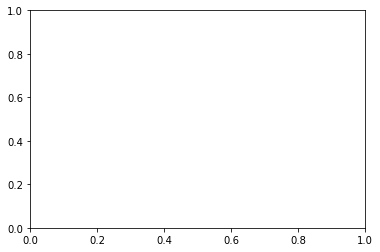

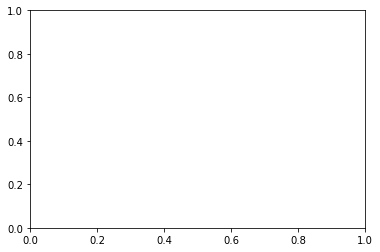

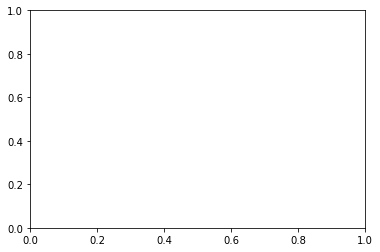

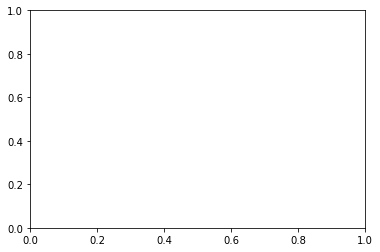

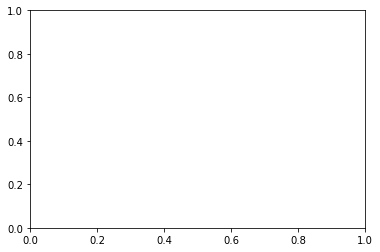

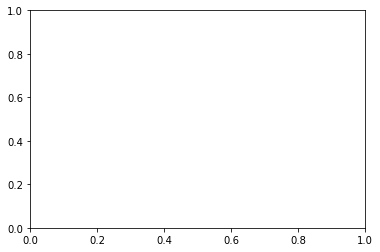

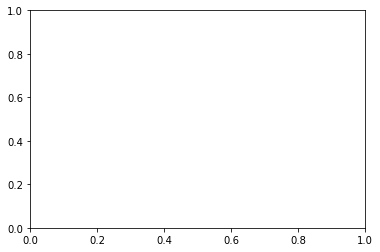

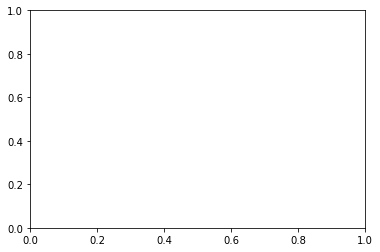

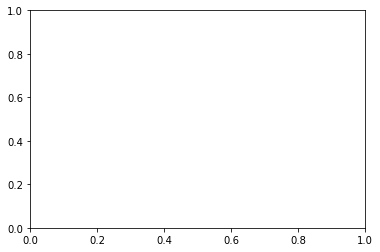

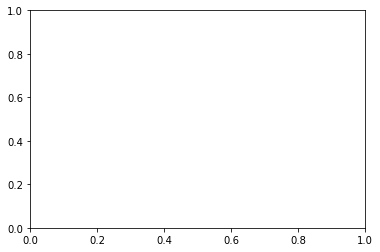

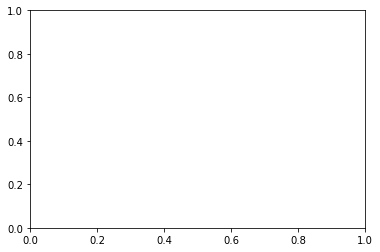

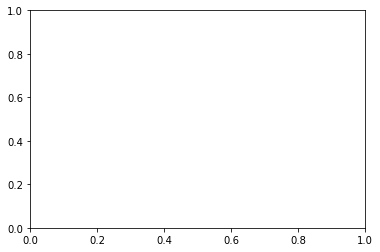

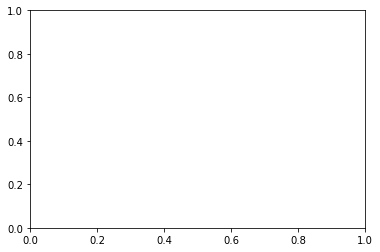

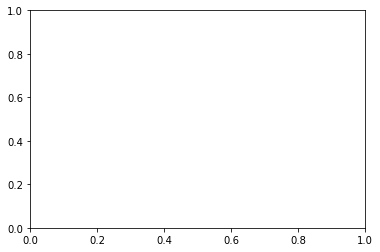

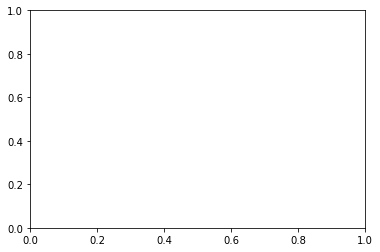

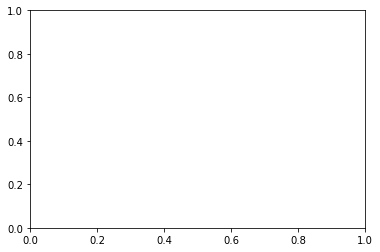

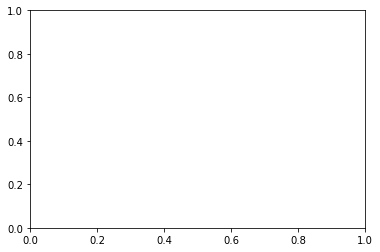

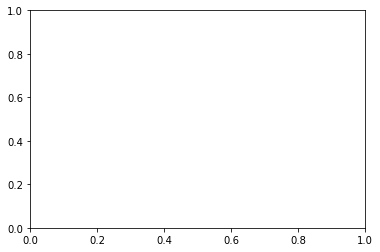

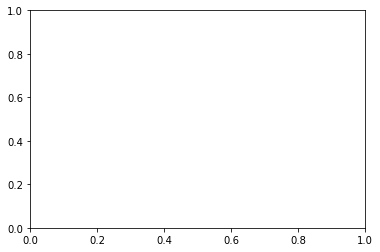

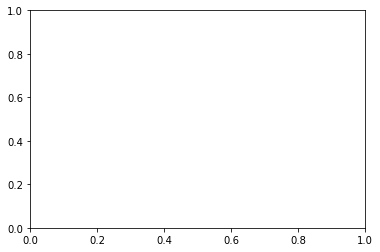

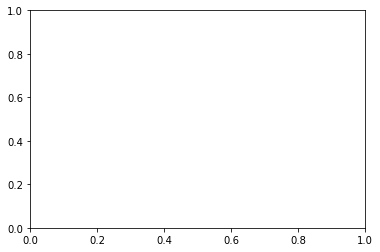

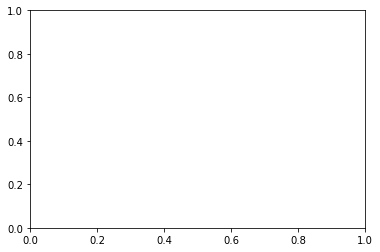

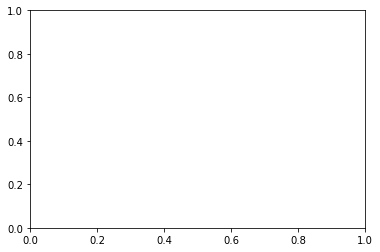

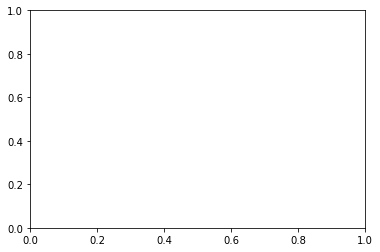

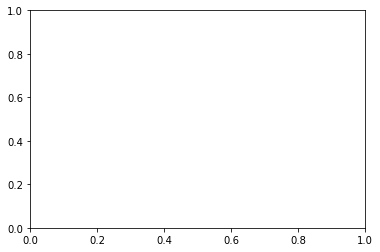

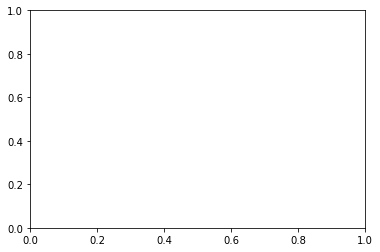

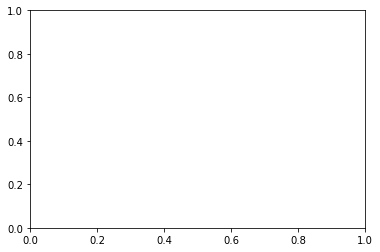

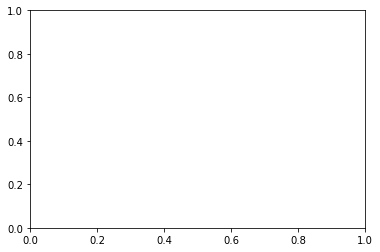

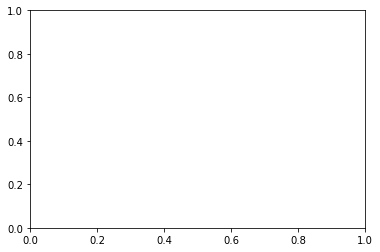

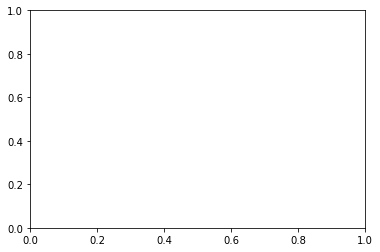

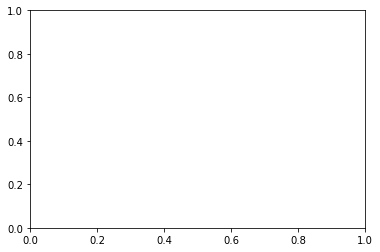

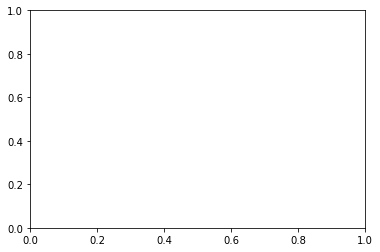

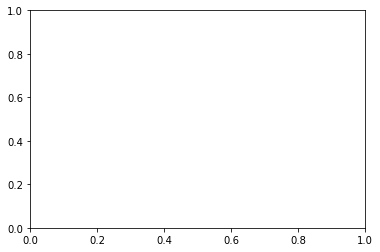

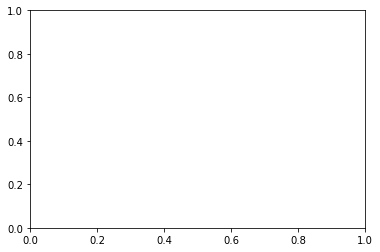

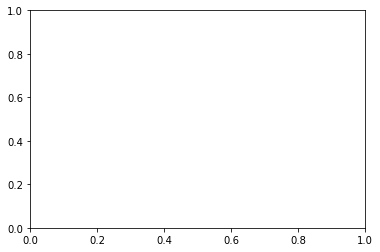

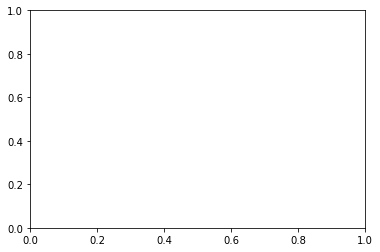

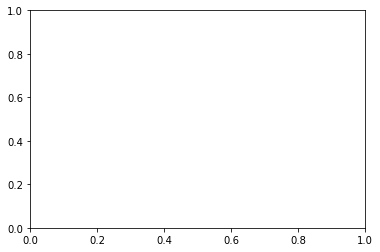

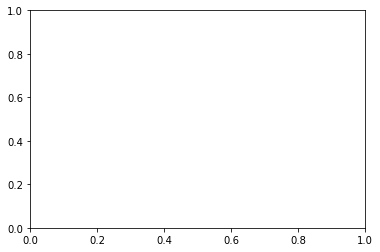

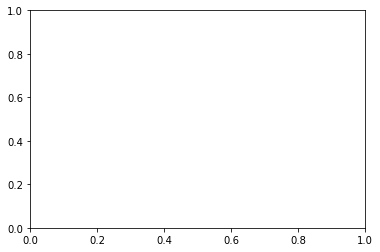

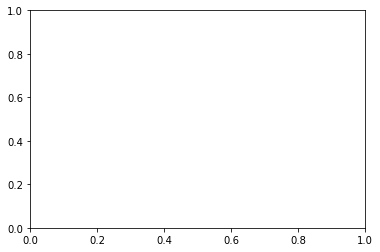

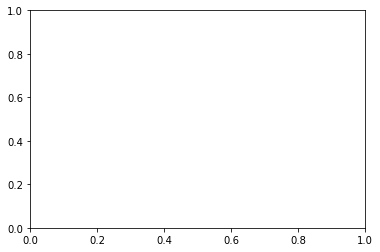

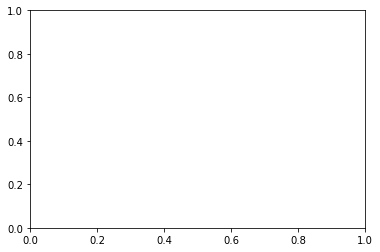

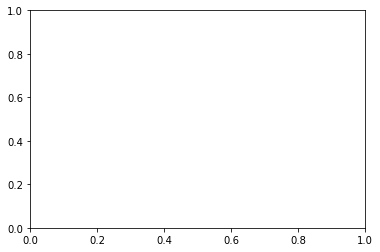

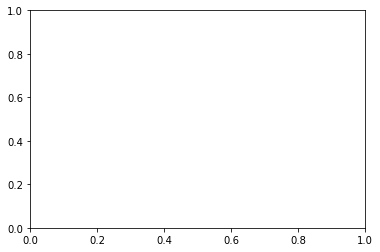

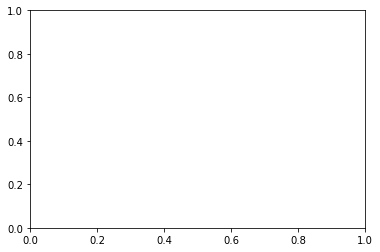

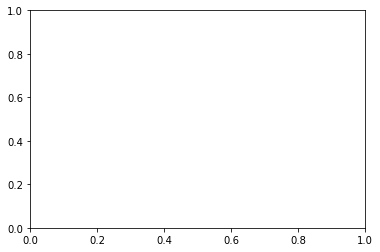

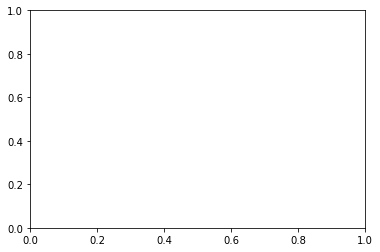

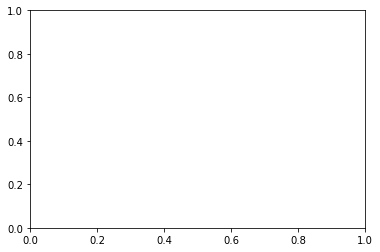

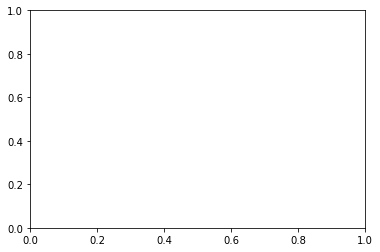

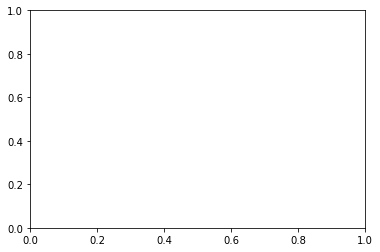

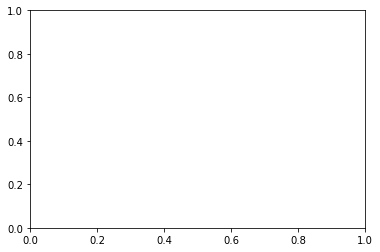

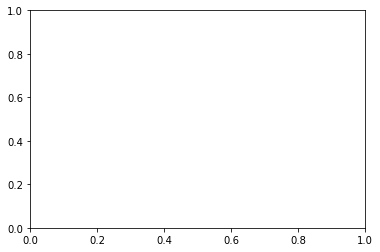

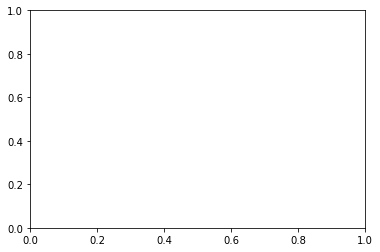

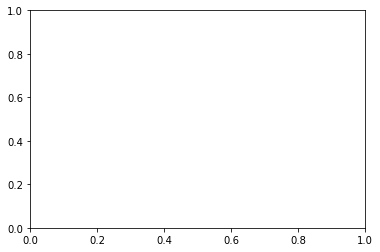

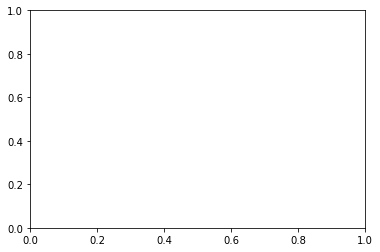

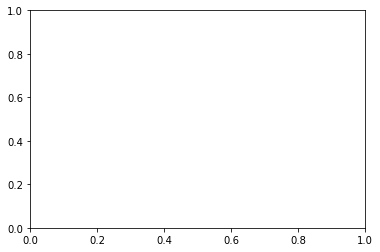

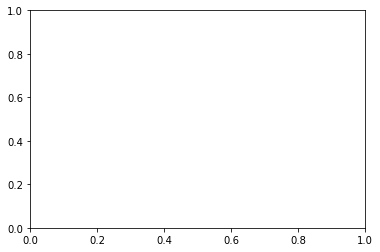

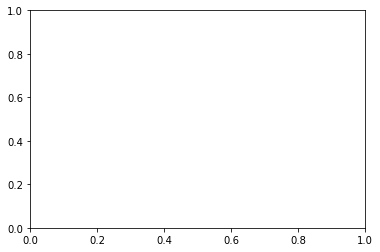

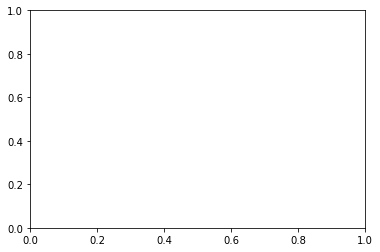

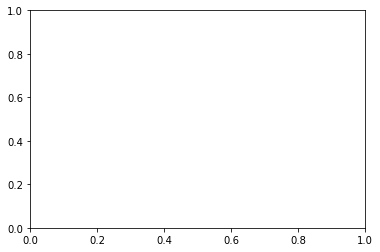

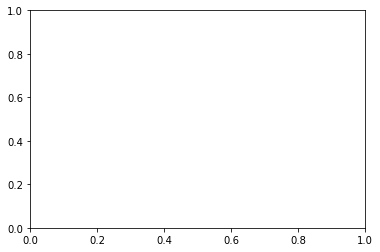

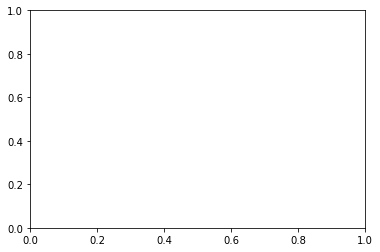

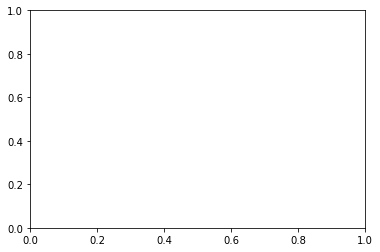

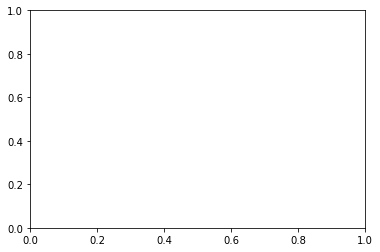

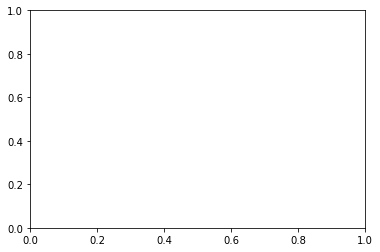

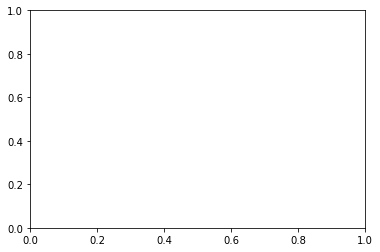

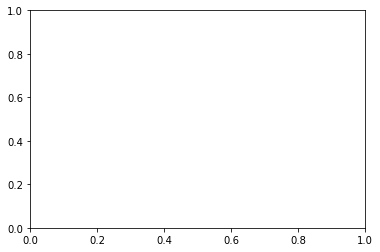

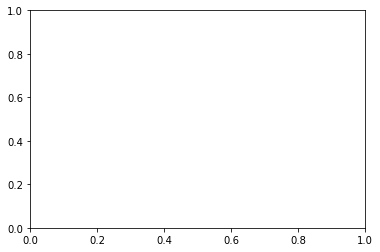

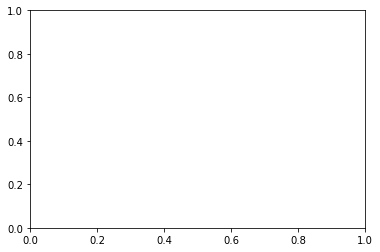

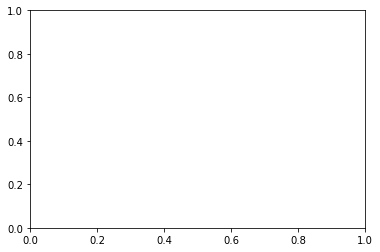

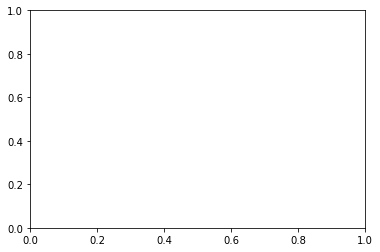

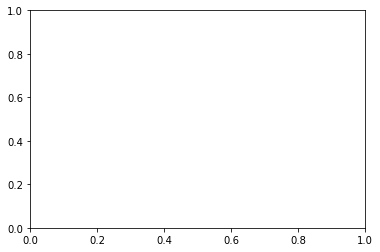

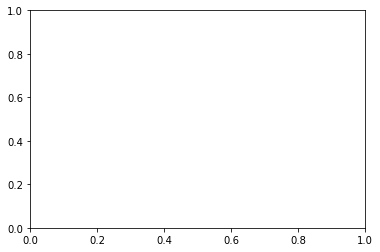

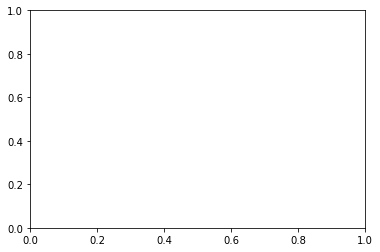

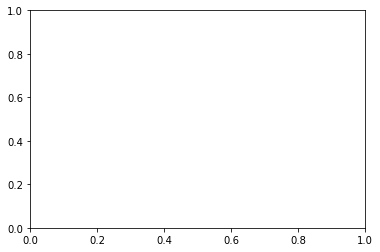

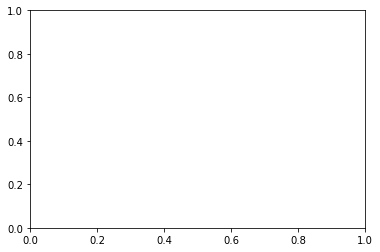

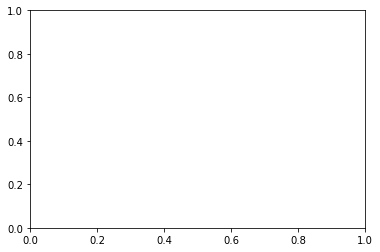

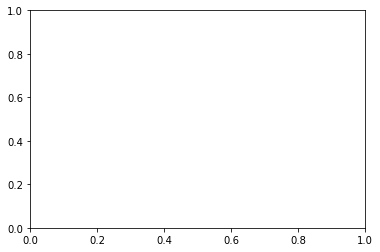

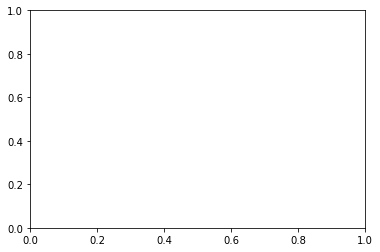

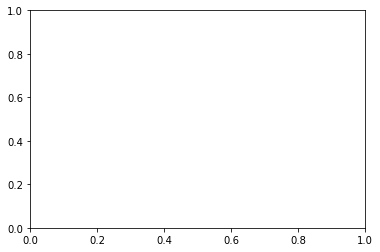

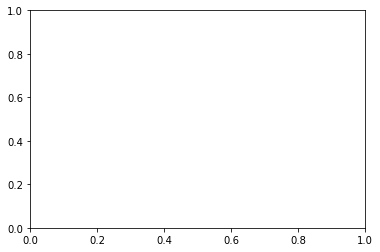

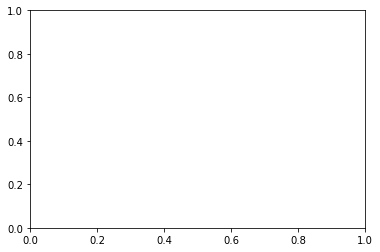

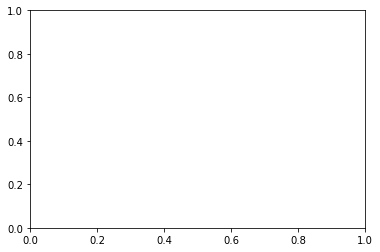

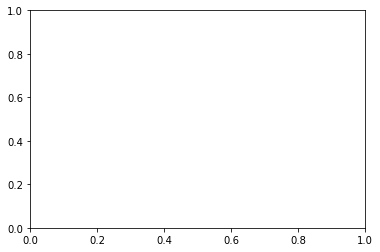

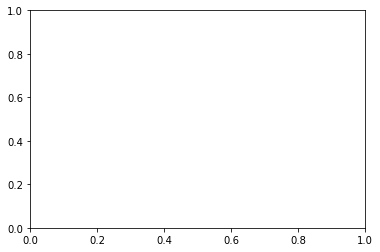

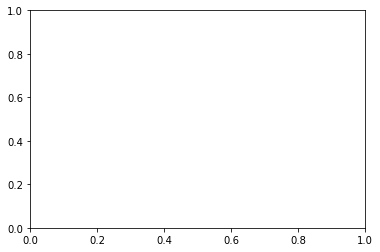

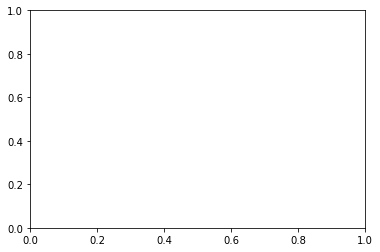

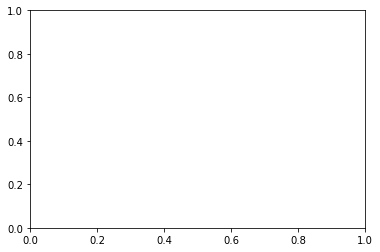

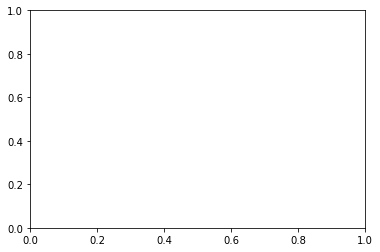

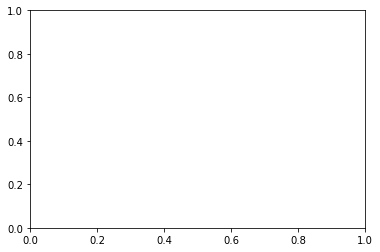

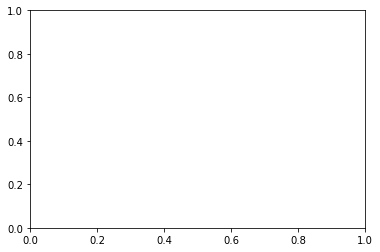

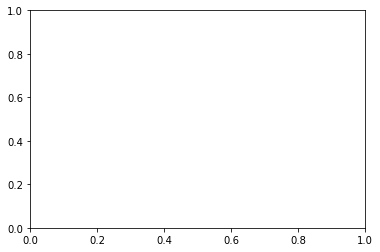

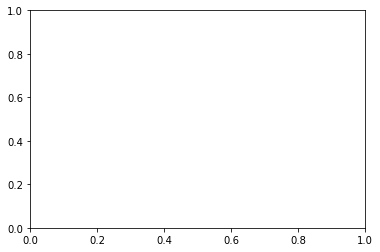

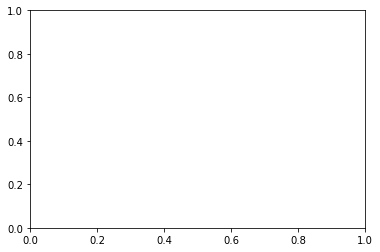

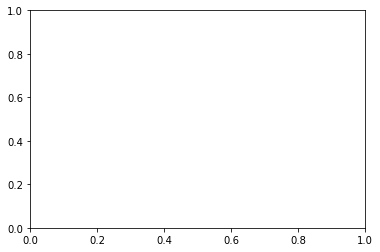

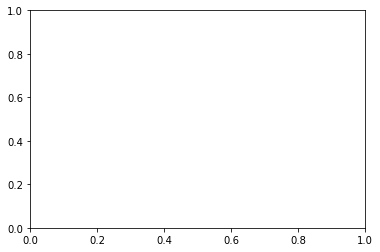

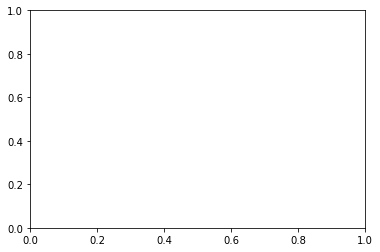

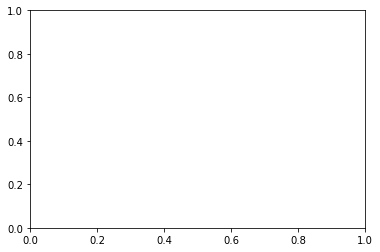

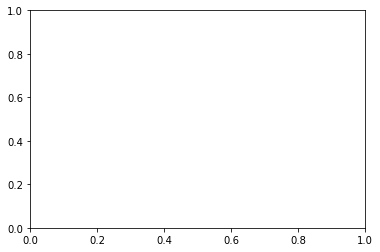

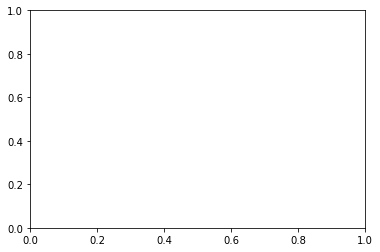

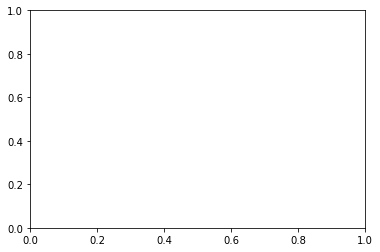

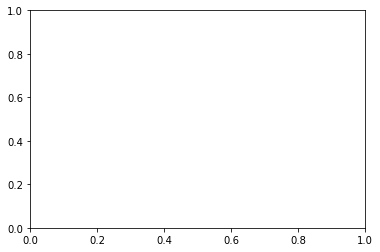

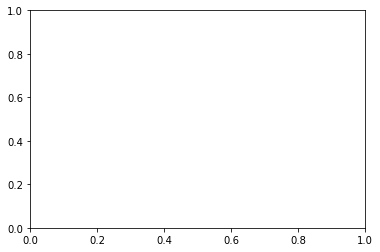

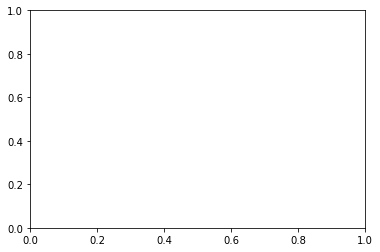

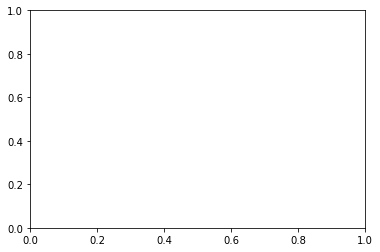

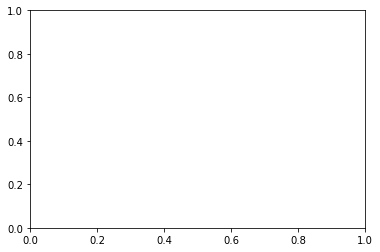

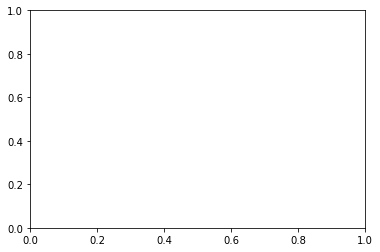

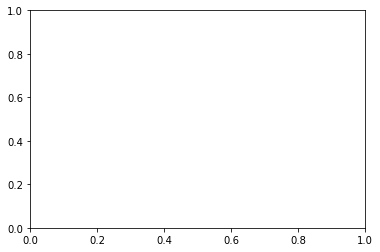

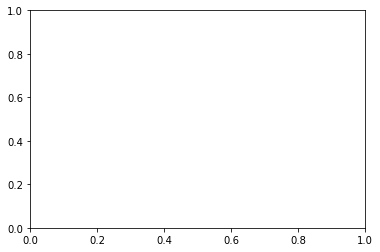

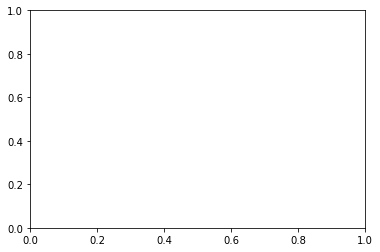

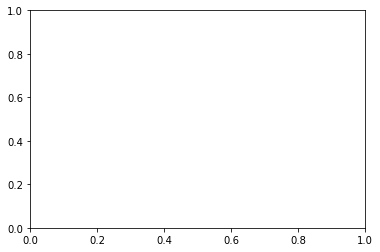

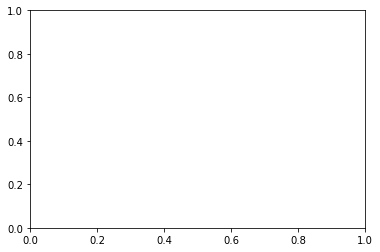

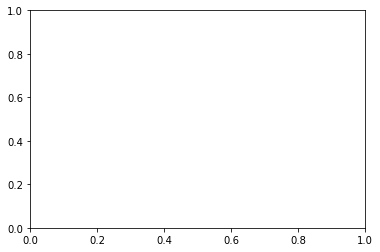

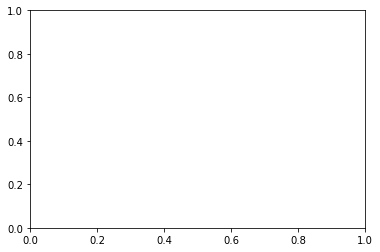

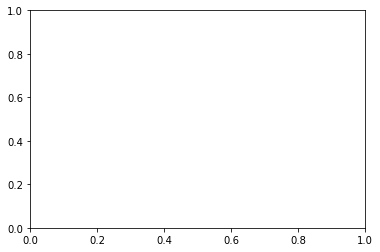

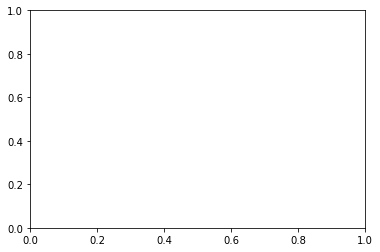

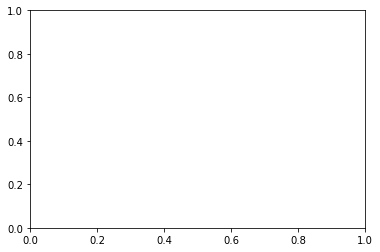

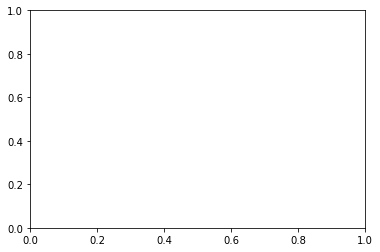

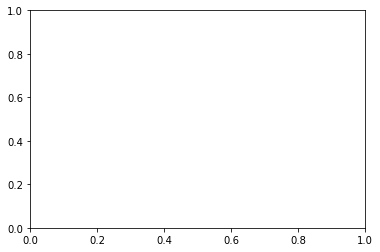

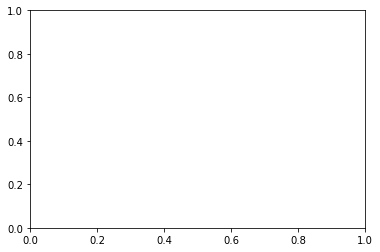

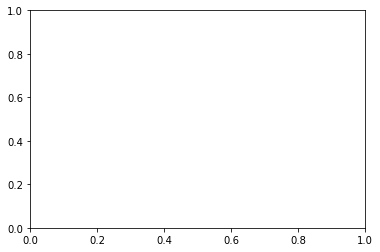

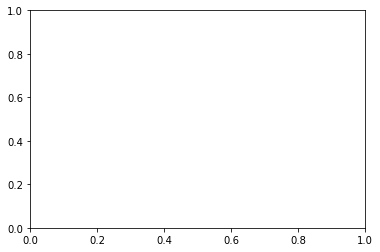

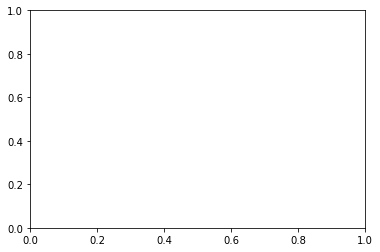

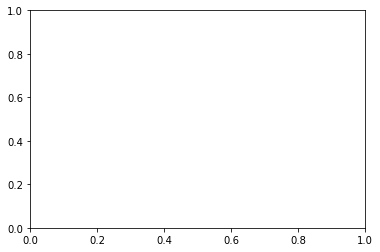

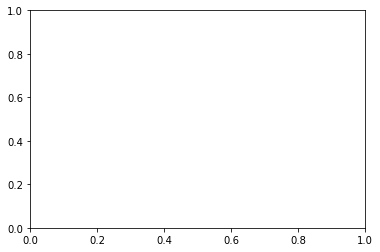

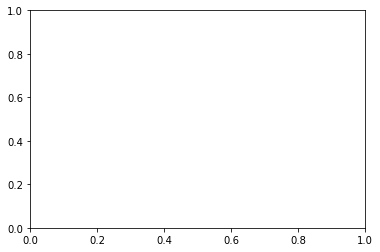

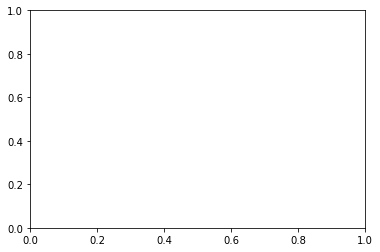

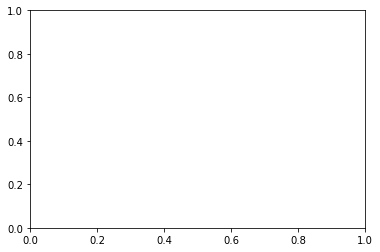

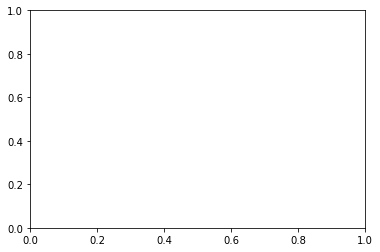

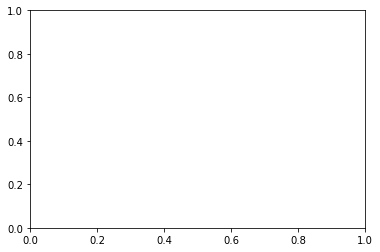

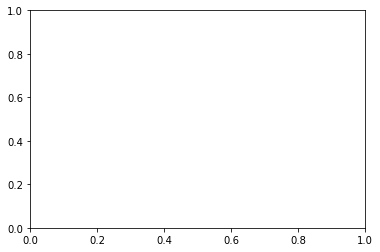

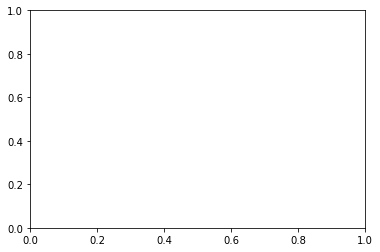

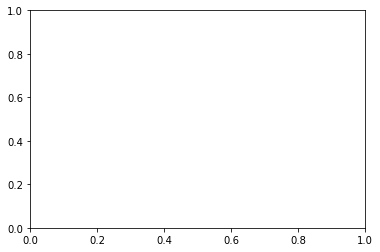

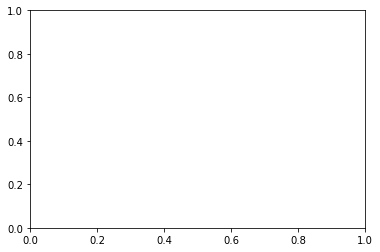

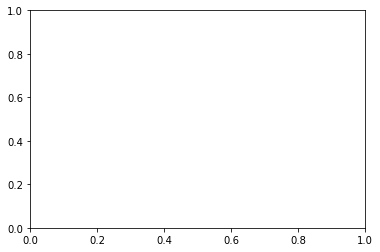

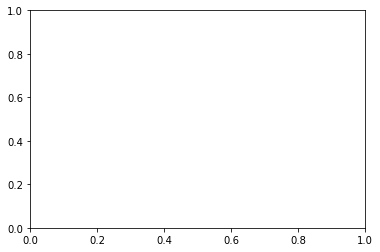

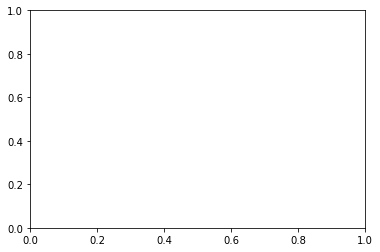

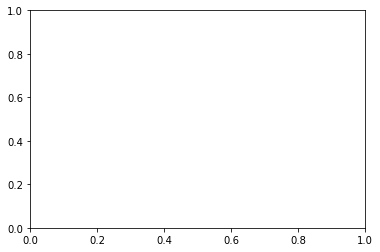

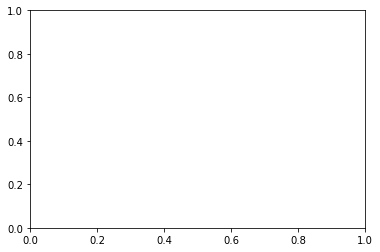

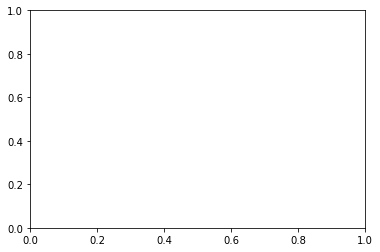

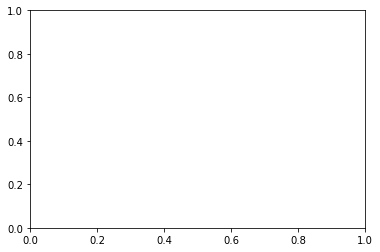

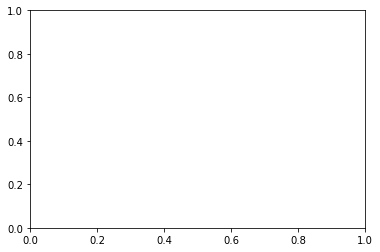

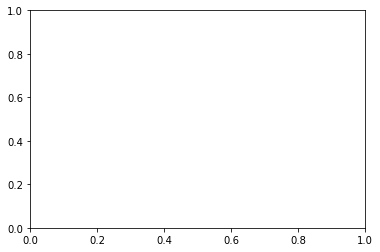

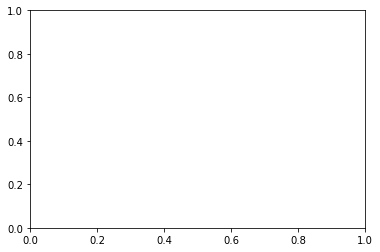

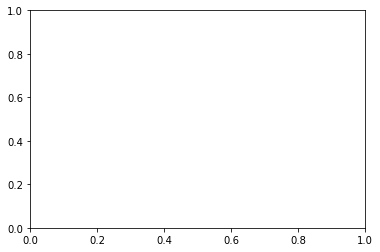

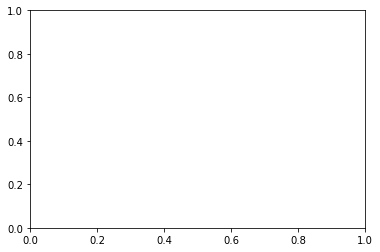

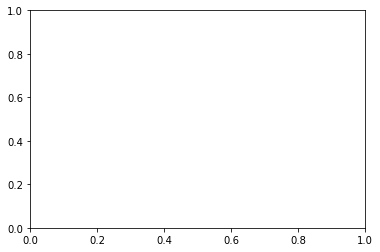

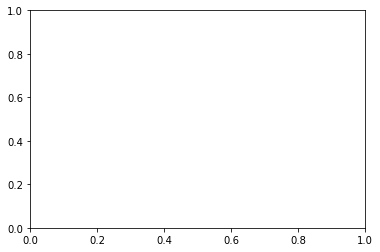

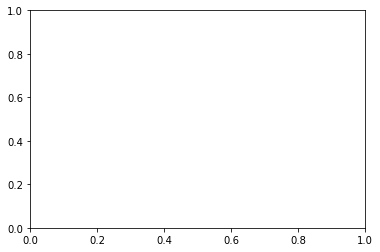

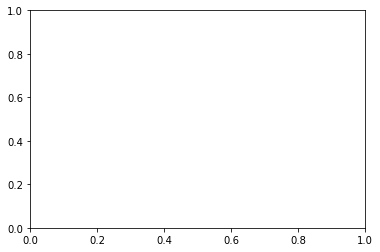

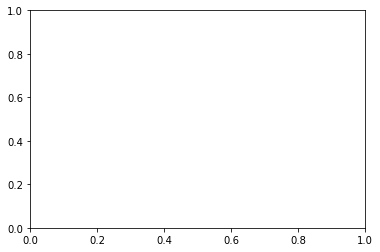

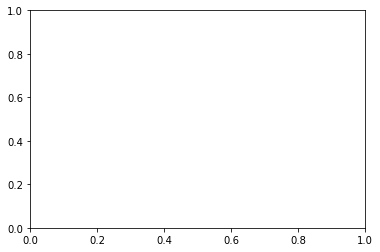

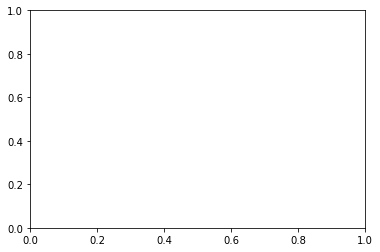

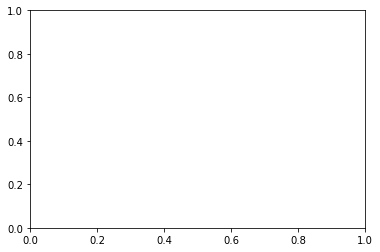

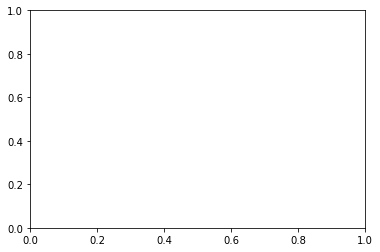

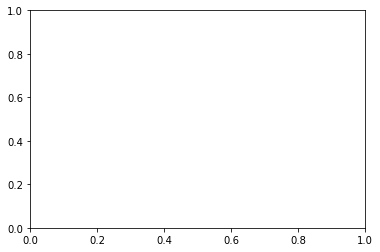

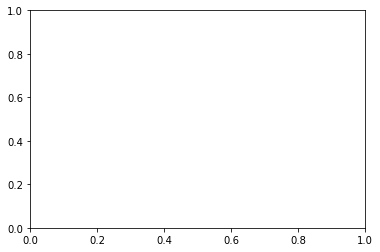

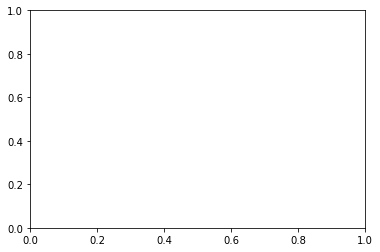

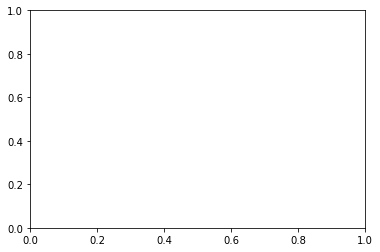

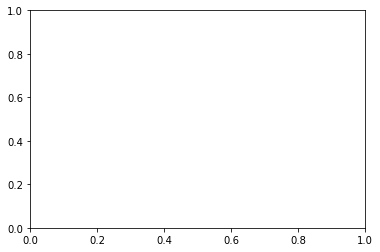

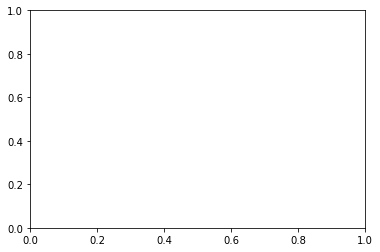

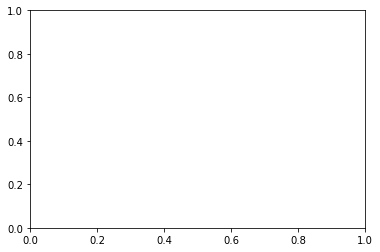

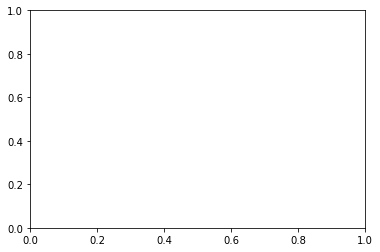

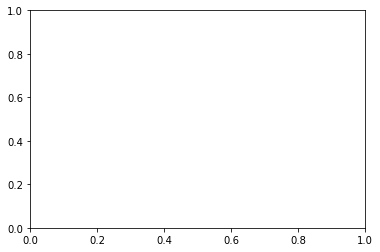

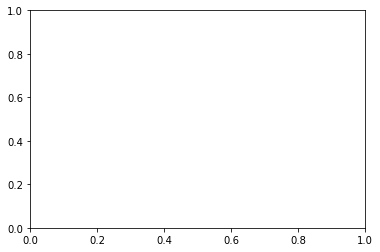

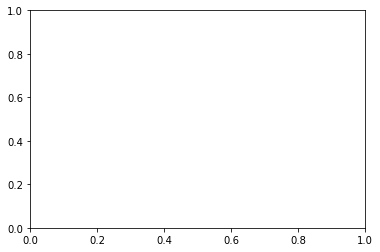

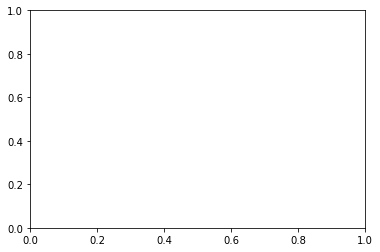

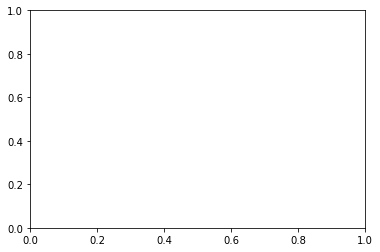

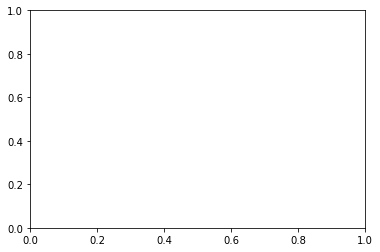

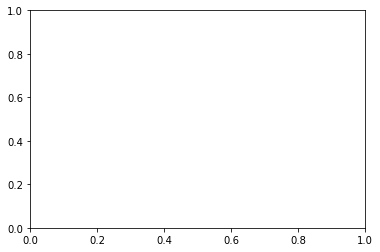

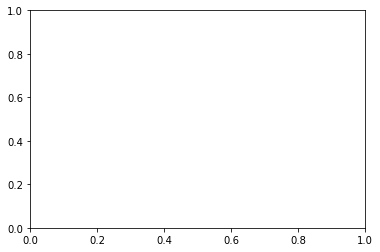

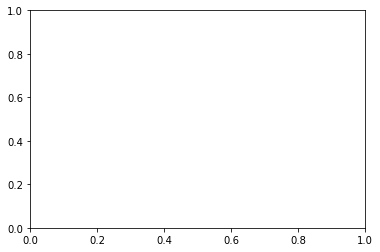

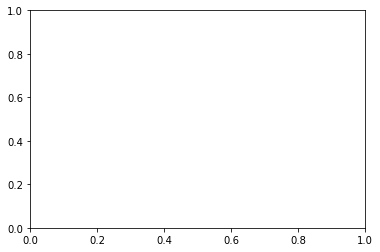

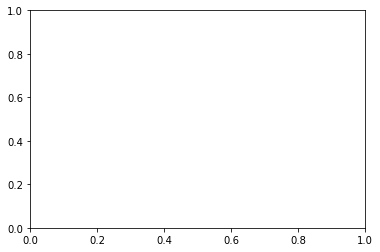

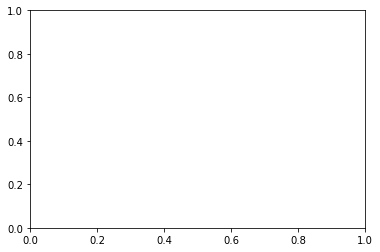

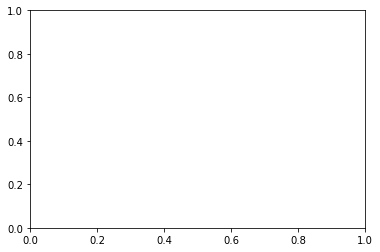

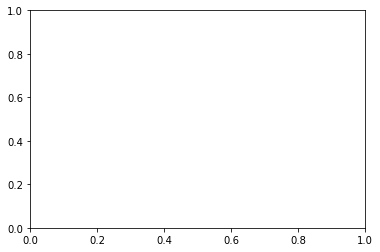

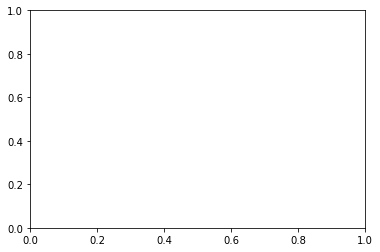

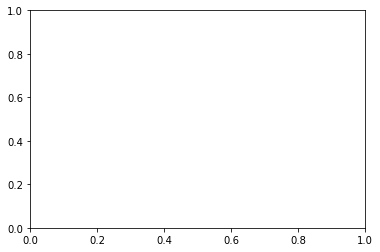

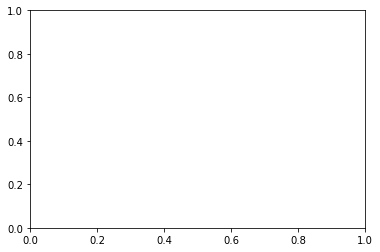

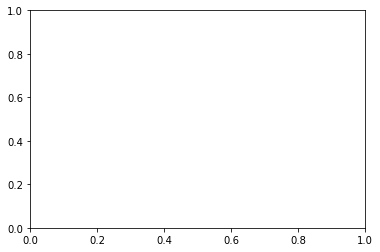

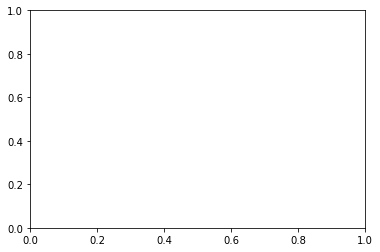

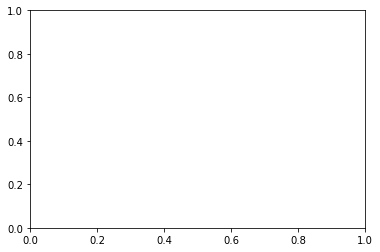

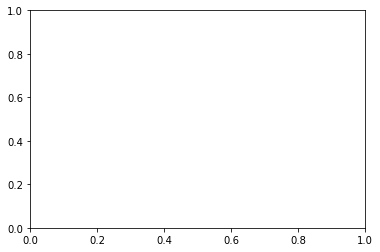

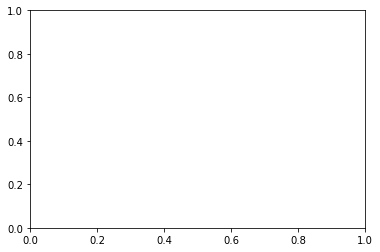

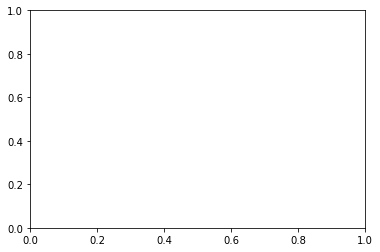

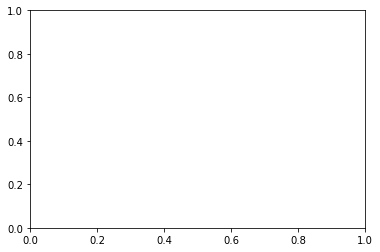

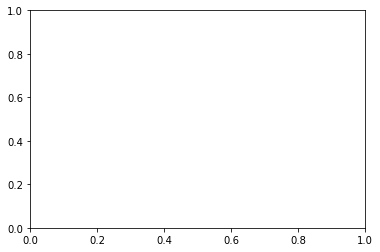

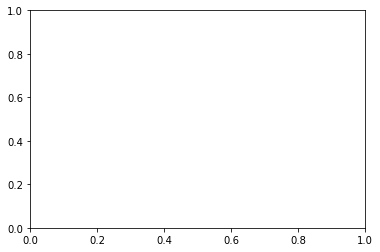

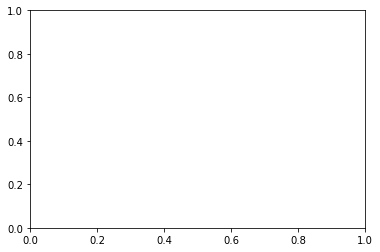

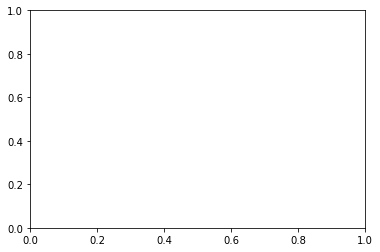

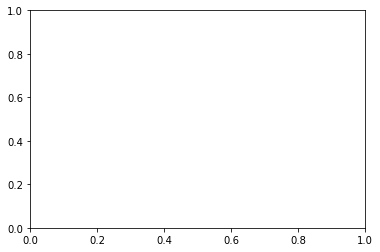

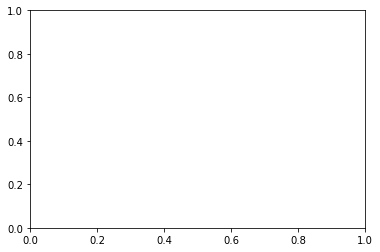

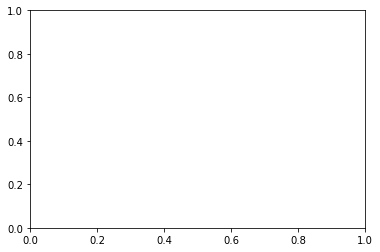

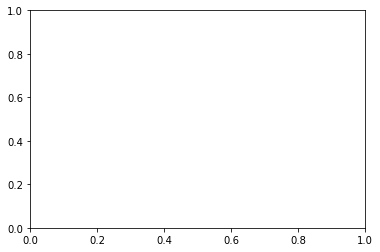

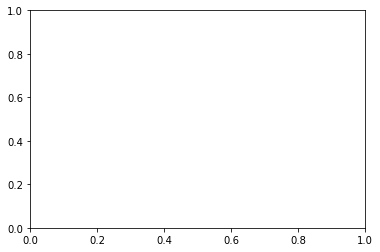

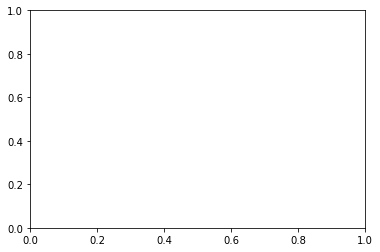

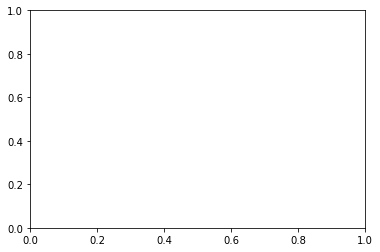

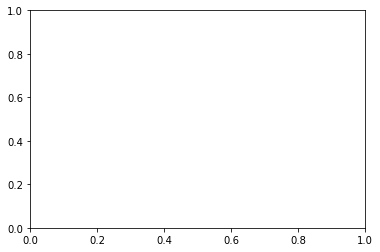

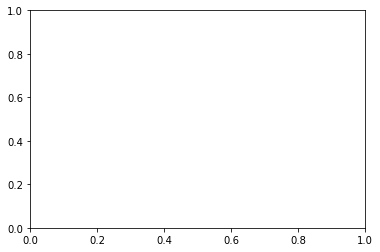

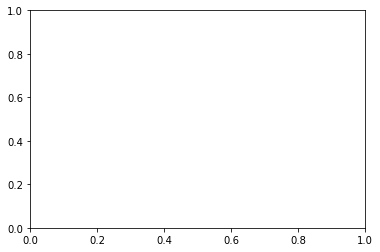

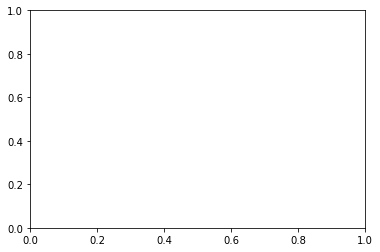

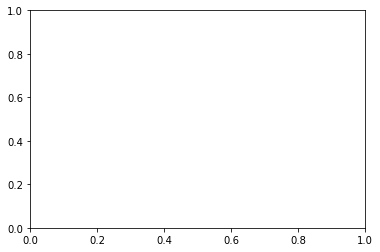

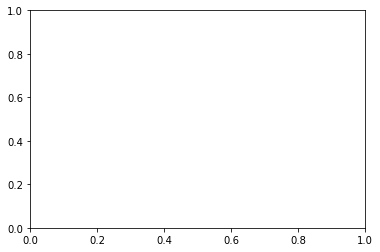

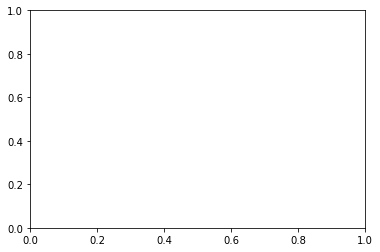

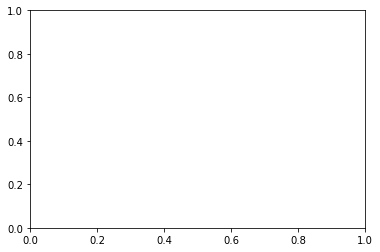

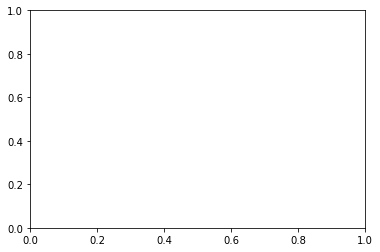

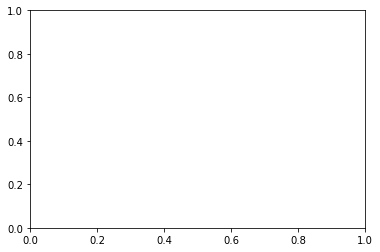

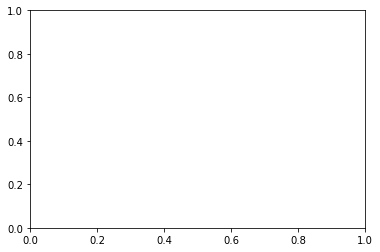

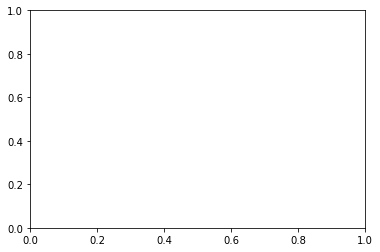

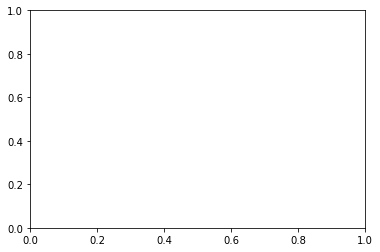

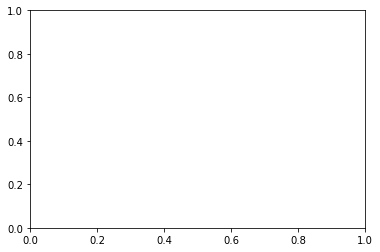

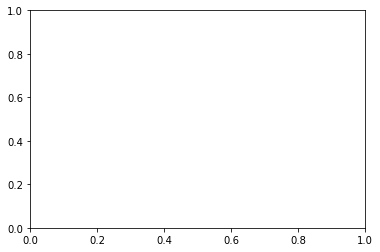

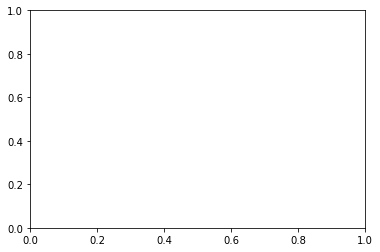

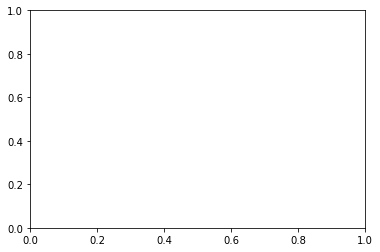

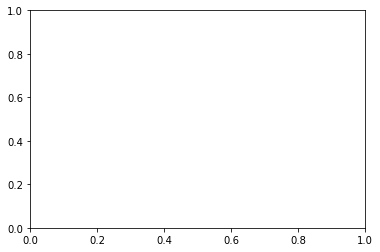

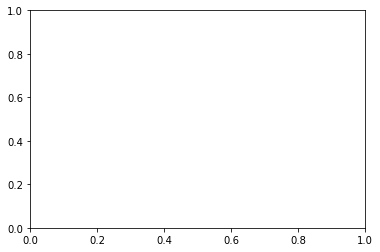

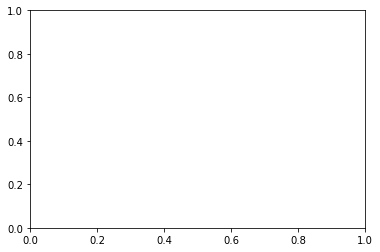

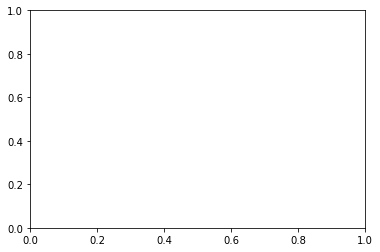

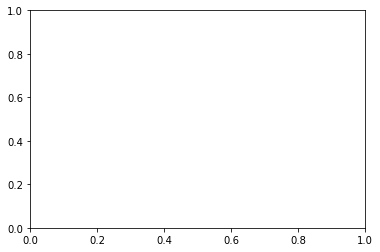

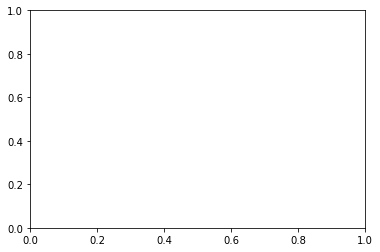

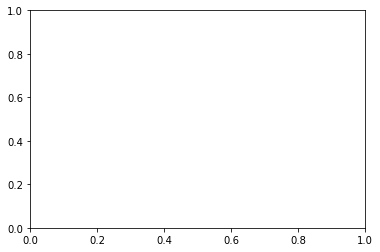

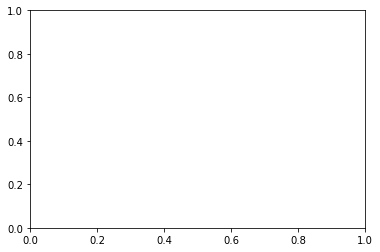

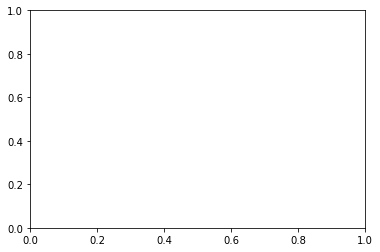

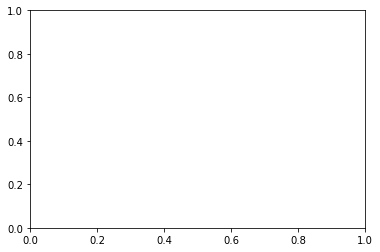

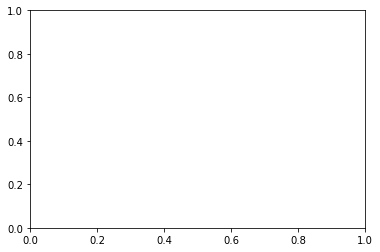

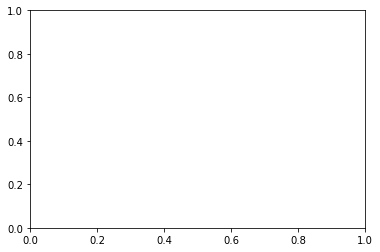

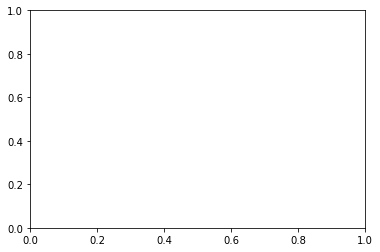

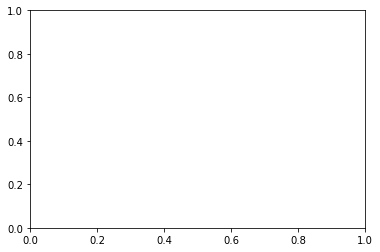

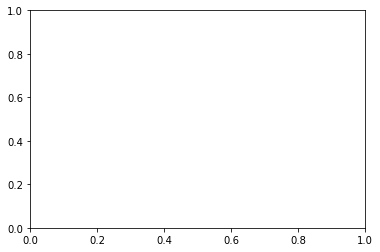

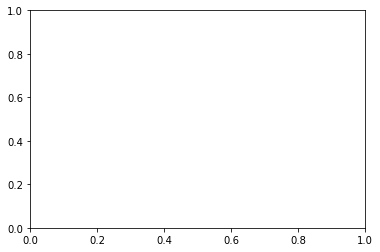

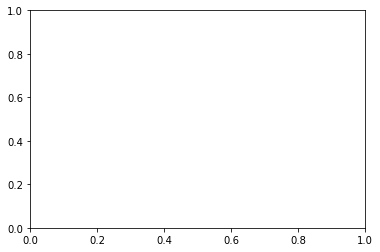

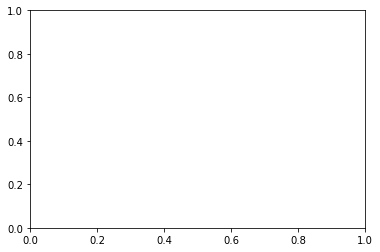

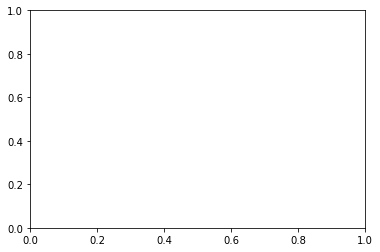

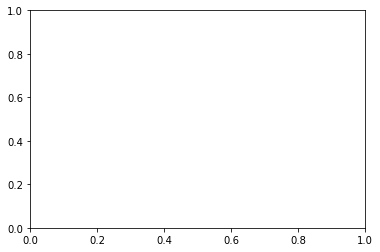

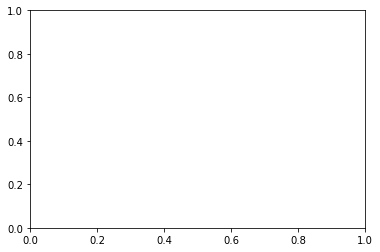

Error in callback <function flush_figures at 0x00000215AC7DF288> (for post_execute):


KeyboardInterrupt: 

In [3]:
np.load.__defaults__=(None, True, True, 'ASCII')
a = np.load('fig_raw_train_data.npy')

In [ ]:
a[0]

Each time if you want to create a new '.npy' file 
MAKE SURE you delete the previous(old) one in the directory!!!! 

In [10]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

raise StopExecution

StopExecution: 

In [2]:
np.load.__defaults__=(None, True, True, 'ASCII')
a = np.load('raw_train_data.npy')
b = np.load('raw_train_data_speed_81.npy')
c = np.load('raw_train_data_speed_107.npy')
d = np.load('raw_train_data_ps1_2.npy')
e = np.load('raw_train_data_ps2_m25.npy')
#np.savez('train.npz',a,b,c,d,e) ############################################################################
#r = np.load('train.npz') ############################################################################
#locals().update(r) ############################################################################
tuple = (a,b,c,d,e)
tuplearr = np.vstack(tuple)
# np.load.__defaults__=(None, True, True, 'ASCII')
dataset = tuplearr
random.shuffle(dataset)
len(dataset)

37296

In [21]:
len(b[746][0])

66150

In [3]:
#To see how many samples are in X-train and y-train
kf = KFold(n_splits=10)

In [7]:
count = 0

for train_set, test_set in kf.split(dataset):
     print( train_set, test_set)
     print("-----------breaking line--------------")
     #X_train, X_test, y_train, y_test = dataset[train_set], dataset[test_set]
 
     print('----------------------------')
     count += 1
     print(count)
     print('----------------------------')
 
     X_train, y_train = zip(*dataset[train_set])
     X_test, y_test = zip(*dataset[test_set])
 
     # Reshape for CNN input
     X_train = np.array([x.reshape( (66150 , 1) ) for x in X_train])
     X_test = np.array([x.reshape( (66150, 1) ) for x in X_test])
 
     # One-Hot encoding for classes
     y_train = np.array(keras.utils.to_categorical(y_train, 10))
     y_test = np.array(keras.utils.to_categorical(y_test, 10))
 
     NAME = "graphic-{}-".format(int(time.time()))
     tensorboard = TensorBoard(log_dir='G1{}'.format(NAME +  str(count)))
 
 
     model = Sequential()

     model.add(
        Conv1D(24, kernel_size=(100), input_shape=(66150 , 1),  kernel_regularizer=keras.regularizers.l2(0.001))
        )

     model.add(MaxPooling1D(20))
     model.add(Activation('relu'))
     model.add(Dropout(rate=0.25))
 
     model.add(Conv1D(48, kernel_size=(10),  kernel_regularizer=keras.regularizers.l2(0.001)))
     model.add(MaxPooling1D(8))
     model.add(Activation('relu'))
     model.add(Dropout(rate=0.25))
 
     model.add(Conv1D(48, kernel_size=(10),  kernel_regularizer=keras.regularizers.l2(0.001)))
     model.add(Activation('relu'))
     model.add(Dropout(rate=0.25))

     model.add(BatchNormalization())
 
     model.add(Flatten())
     model.add(Dropout(rate=0.25))
 
     model.add(Dense(64))
     model.add(Activation('relu'))
     model.add(Dropout(rate=0.25))
 
     model.add(Dense(10))
     model.add(Activation('softmax'))
 
     #convnet = tflearn.DNN(model, tensorboard_dir='log')
 
     model.compile(
 	    optimizer="Adam",
 	    loss="categorical_crossentropy",
 	    metrics=['accuracy']
        )
 
     model.fit(
 	    x=X_train, 
 	    y=y_train,
        epochs=3,
        batch_size=128,
        validation_data= (X_test, y_test),
 	    callbacks=[tensorboard]
 	    )
 
     score = model.evaluate(
 	    x=X_test,
 	    y=y_test
        )
 
     print('Test loss:', score[0])
     print('Test accuracy:', score[1])

     model.save('SoundClassification-G1-' + str(count) + '.model')  

    

    


[ 3730  3731  3732 ... 37293 37294 37295] [   0    1    2 ... 3727 3728 3729]
-----------breaking line--------------
----------------------------
1
----------------------------
Epoch 1/3
263/263 [==============================] - 712s 3s/step - loss: 1.6221 - accuracy: 0.4493 - val_loss: 2.0477 - val_accuracy: 0.5335
Epoch 2/3
263/263 [==============================] - 701s 3s/step - loss: 1.1644 - accuracy: 0.6206 - val_loss: 1.0995 - val_accuracy: 0.7408
Epoch 3/3
117/117 [==============================] - 7s 58ms/step - loss: 0.7600 - accuracy: 0.7767
Test loss: 0.7599822282791138
Test accuracy: 0.7766755819320679
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: SoundClassification-G1-1.model\assets
[    0     1     2 ... 37293 37294 37295] [3730 3731 3732 ... 7457 7

In [22]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

raise StopExecution

StopExecution: 

In [ ]:

for i in range(1, 11):

    model = tf.keras.models.load_model('SoundClassification-G1-' + str(i) + '.model')
    def prepare(filepath):
        y, sr = librosa.load(filepath, duration=3)
        if(len(y) == 66150):
            new_image_width = 66150
            y = np.full(new_image_width, 66150-len(y))
            return y.reshape(-1,66150, 1)

        else:
            return y.reshape(-1, 66150, 1)
    
    from os import walk

    mypath = 'Test/'
    f = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        f.extend(filenames)
        break
    print(len(f))
    print(f)

    count = 0

    for file in f:
        count += 1
        prediction = model.predict([prepare('Test/'+file)])
        y_classes = prediction.argmax(axis=-1)
        max = np.amax(prediction)
        print(str(count) + " th")
        print(file)
        print("Match accuracy: " + str(max))
        print("class: " + str(y_classes))
        print(prediction)
        print("-------------------------------------")